Get statistics, plots, & info for the final v4 sequences.

In [32]:
%load_ext autoreload
%autoreload 1
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
! export NUPACKHOME="/ssd1/home/kdorosch/software/nupyck/lib/nupack"

In [34]:
import os
import subprocess
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import nupyck
from _ucrdtw import ucrdtw
from natsort import natsorted
from pore_utils.smith_waterman import s_w
import imageio
import importlib
importlib.reload(nupyck)

sns.set(font_scale=1.5, style="white")

In [35]:
def simulate_squiggle(sequence):
    rand = np.random.randint(0, 500000)
    temp_fasta_fname = sequence + "_" + str(rand) + "_temp.fa"
    temp_scrappie_fname = sequence + "_" + str(rand) + "_temp.scrappie"
    with open(temp_fasta_fname, "w") as f:
        f.write(">temp\n%s\n" % (sequence))    
    scrappie_str = "scrappie squiggle -o %s %s" % (temp_scrappie_fname, temp_fasta_fname)
    os.system(scrappie_str)
    os.remove(temp_fasta_fname)
    
    with open(temp_scrappie_fname, "r") as f:
        scrappie_lines = f.readlines()
    os.remove(temp_scrappie_fname)
    
    scrappie_sim = []
    seq_name = None
    df = None
    for i, line in enumerate(scrappie_lines):
        line = line.strip()
        if line.startswith("#"):
            seq_name = line
        elif line.startswith("pos"):
            continue
        else:
            scrappie_sim.append(line.split("\t"))
    df = pd.DataFrame(scrappie_sim, columns=["pos", "base", "current", "sd", "dwell"])
    df = df.astype({"pos": int, "base": str, "current": float, "sd": float, "dwell": float})
    return df

In [36]:
def calc_dtw_from_seq(seq_1, seq_2, warp_width=0.1):
    scrappie_df_1 = simulate_squiggle(seq1)
    scrappie_df_2 = simulate_squiggle(seq2)
    dtw_dist = calc_dtw(scrappie_df_1, scrappie_df_2, warp_width=warp_width)


def calc_dtw(scrappie_df_1, scrappie_df_2, warp_width=0.1):
    _, dtw_dist = ucrdtw(scrappie_df_1, scrappie_df_2, warp_width, False)
    dtw_dist = np.float32(dtw_dist)
    return dtw_dist


def initialize_distance(sequences):
    n_seqs = len(sequences)
    D_dtw = np.zeros((n_seqs, n_seqs))
    D_sw = np.zeros((n_seqs, n_seqs))
    scrappie_dfs = [None for _ in range(n_seqs)]
    squiggles = [None for _ in range(n_seqs)]
    for j in range(n_seqs):
        if scrappie_dfs[j] is None:
            scrappie_dfs[j] = simulate_squiggle(sequences[j])
            squiggles[j] = list(scrappie_dfs[j]["current"])
        for i in range(n_seqs):
            if scrappie_dfs[i] is None:
                scrappie_dfs[i] = simulate_squiggle(sequences[i])
                squiggles[i] = list(scrappie_dfs[i]["current"])
            if i > j:
                continue
            else:
                dtw_dist = calc_dtw(squiggles[i], squiggles[j])
                D_dtw[i, j] = dtw_dist
                D_dtw[j, i] = dtw_dist
                
                _, sw_dist, _, _,  _ = s_w(sequences[j], sequences[i], cost_fn={"match": 1, "mismatch": -1, "gap": -8})
                D_sw[i, j] = sw_dist
                D_sw[j, i] = sw_dist
    return D_dtw, D_sw, scrappie_dfs

In [37]:
def plot_scrappie_squiggle(scrappie_df, seq_name="", dwell_time=7):
    squiggle = []
    for x in scrappie_df.current:
        for _ in range(dwell_time):
            squiggle.append(x)
    seq = "".join(scrappie_df.base)
    figwidth = len(squiggle) / len(seq)    
    fig, ax = plt.subplots(figsize=(figwidth, 4))
    ax.plot(squiggle, c="k")
    ax.set_xlabel("Observations")
    ax.set_ylabel("Normalized pA")
    ax.set_title("%s\n%s" % (seq_name, seq))
    ax.set_xlim([0, len(squiggle)])
    ax.set_ylim([-2.5, 2.5])
    ax.axhline(0, c="k", alpha=0.5)
    return fig, ax

In [60]:
seq_file = "../headers/v4_sequences.fa"
sequences = []
with open(seq_file, "r") as f:
    for line in f:
        if line.startswith(">"):
            continue
        else:
            sequences.append(line.strip())
assert len(sequences) == 96


In [61]:
D_dtw, D_sw, scrappie_dfs = initialize_distance(sequences)

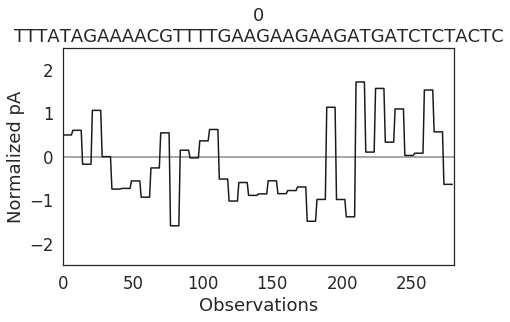

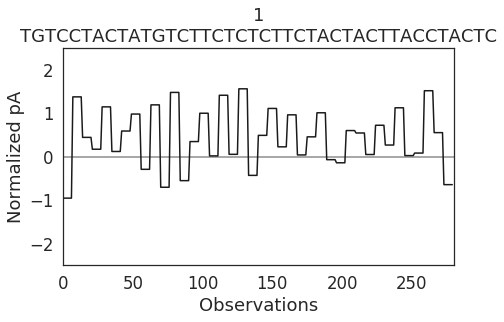

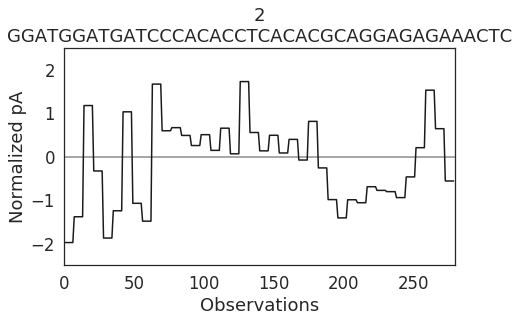

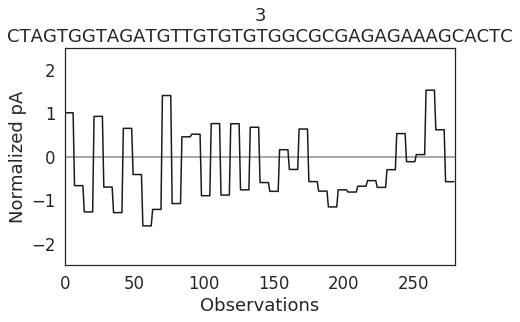

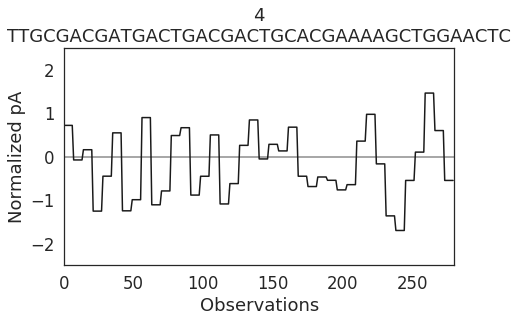

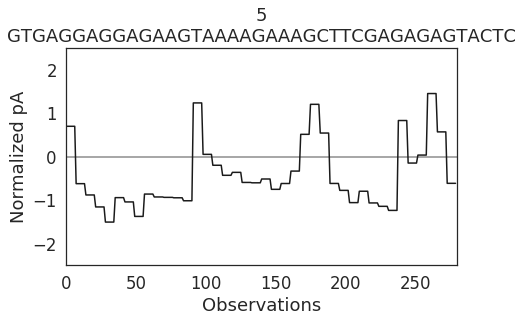

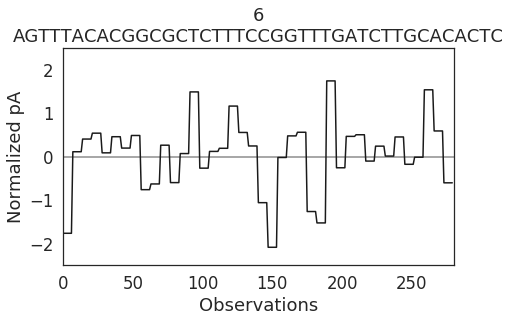

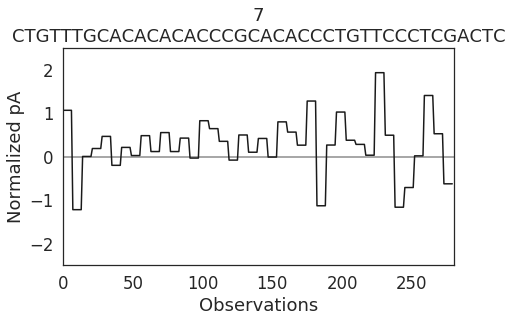

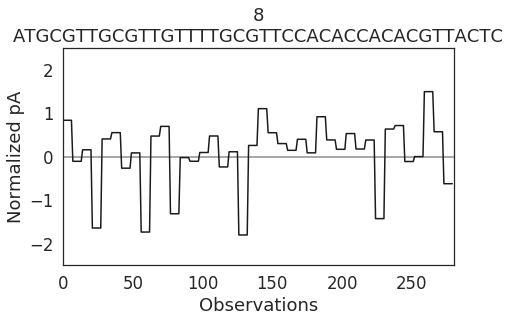

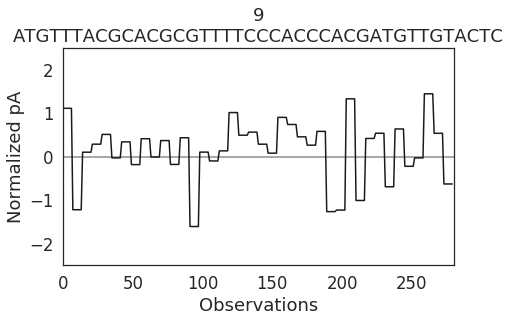

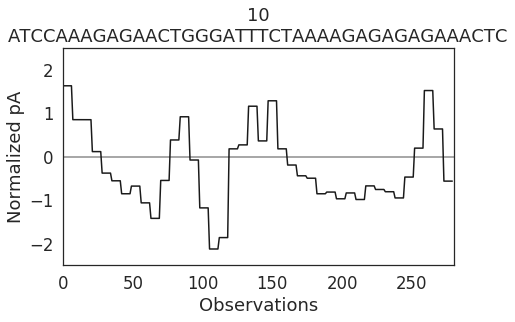

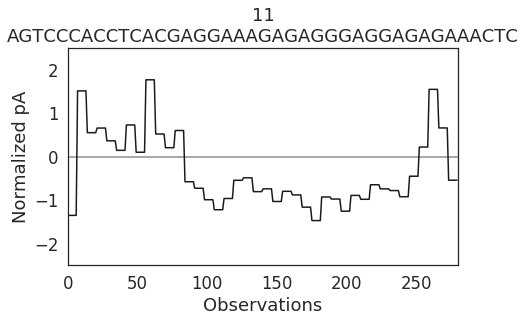

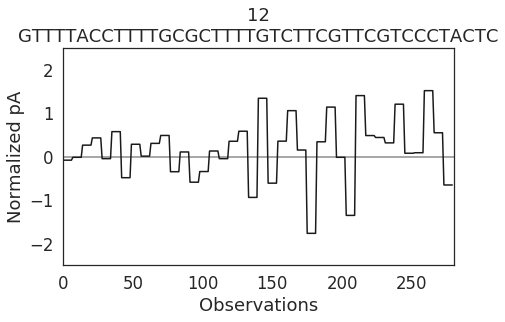

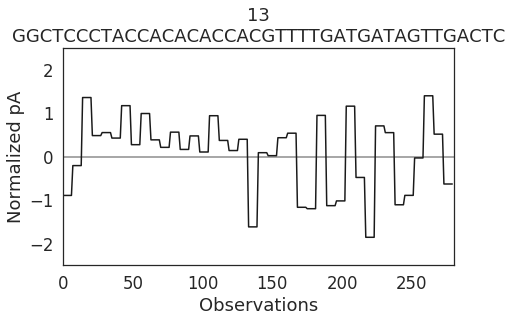

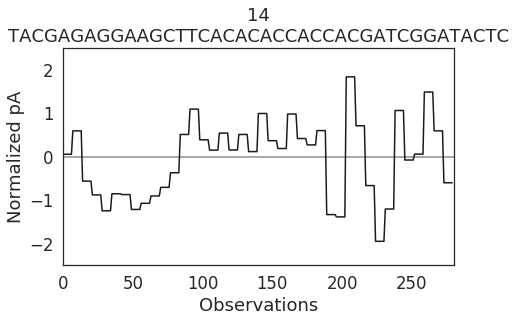

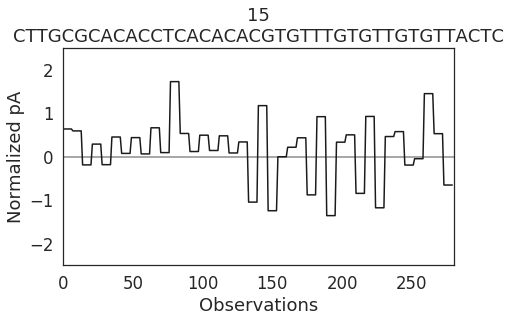

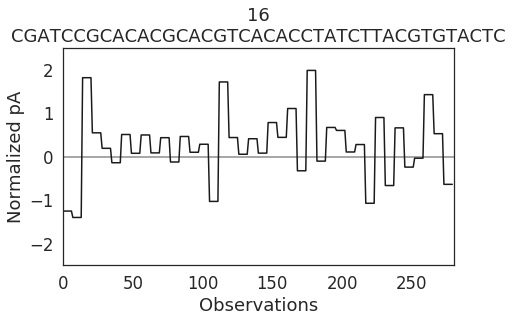

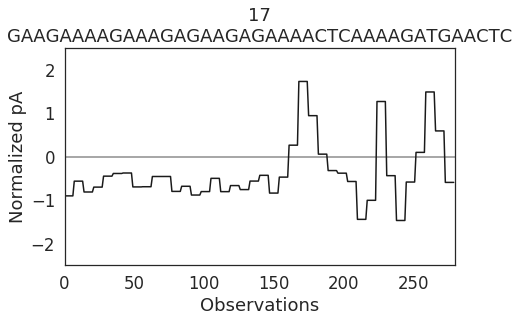

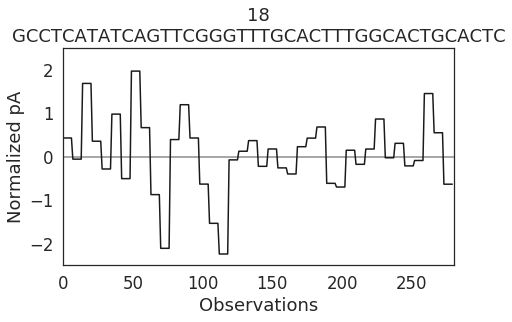

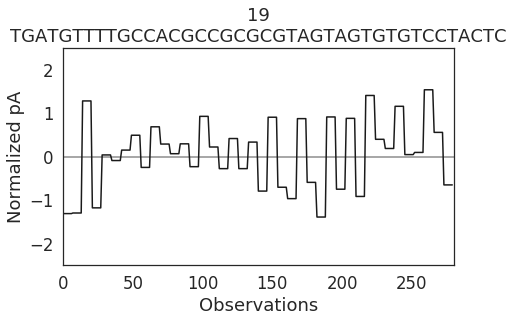

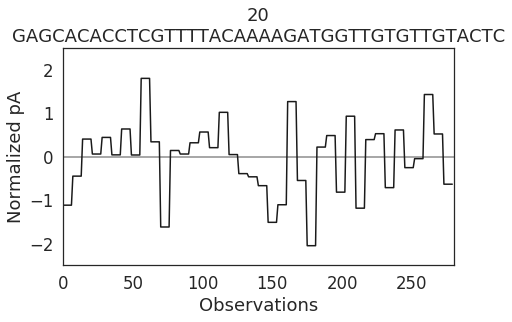

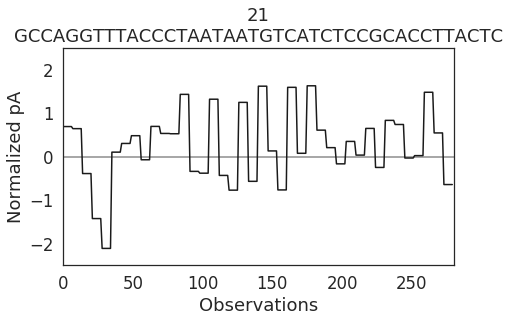

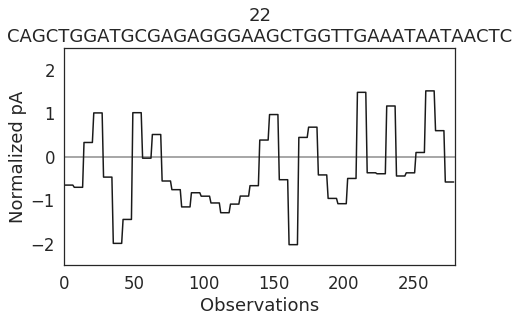

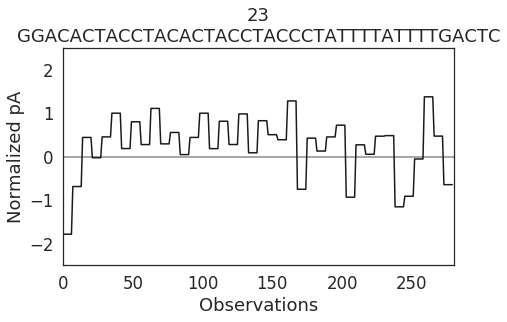

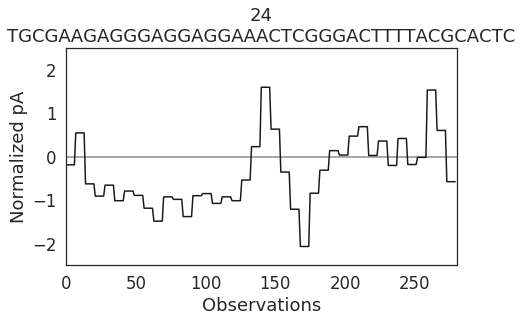

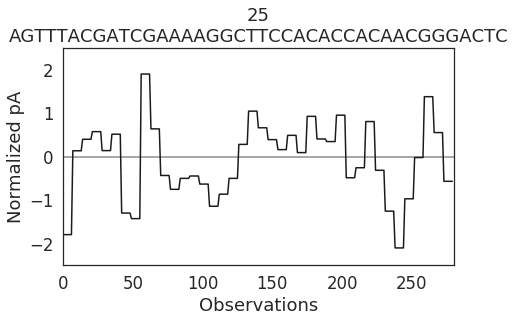

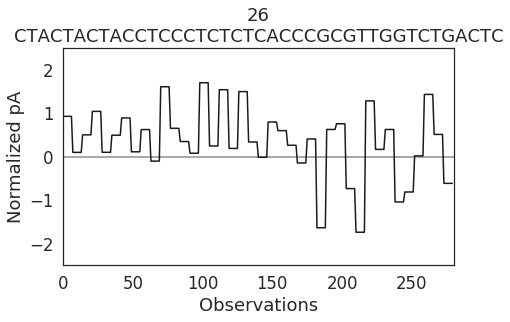

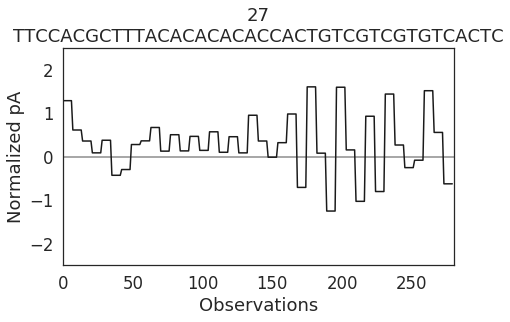

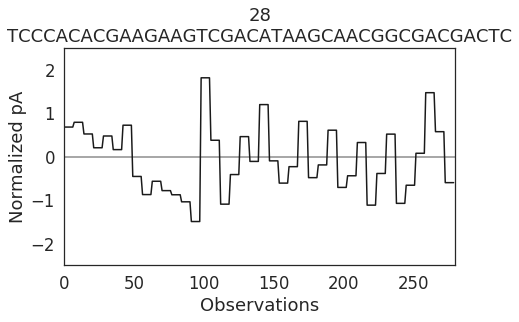

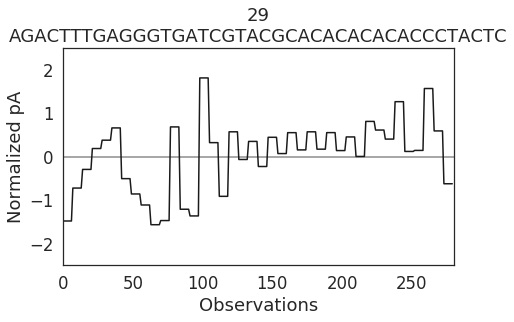

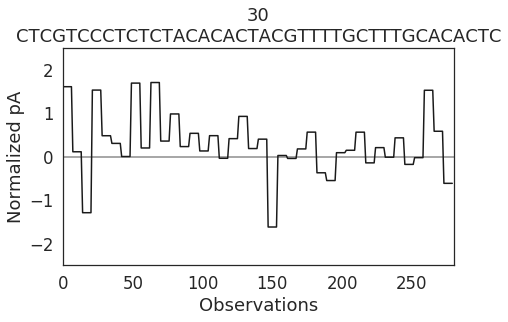

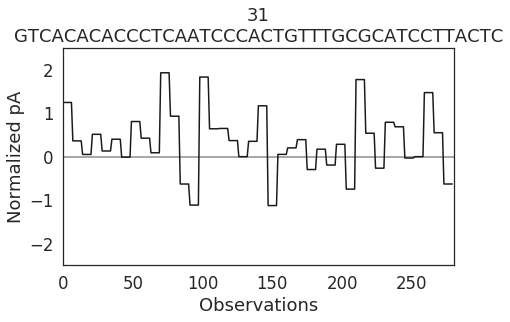

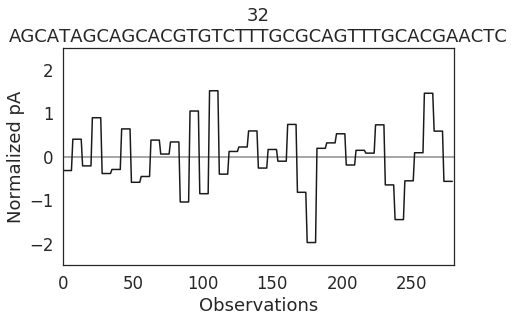

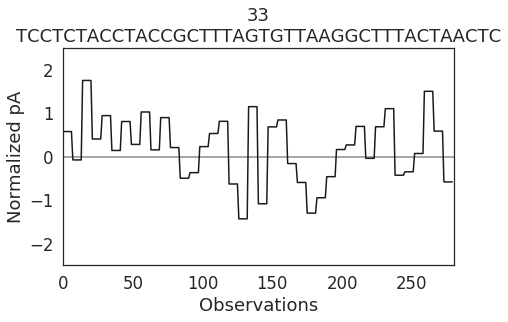

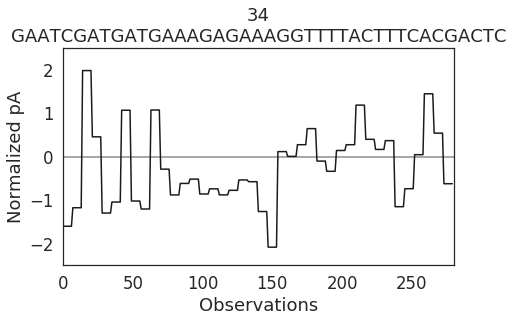

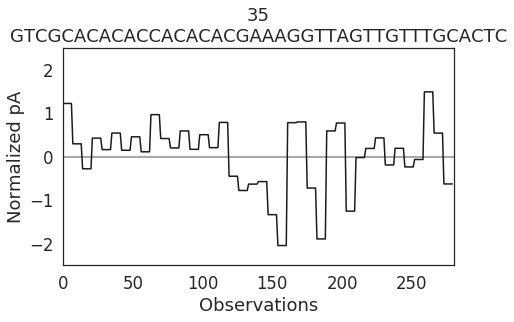

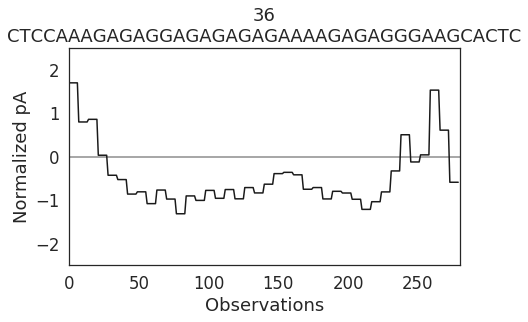

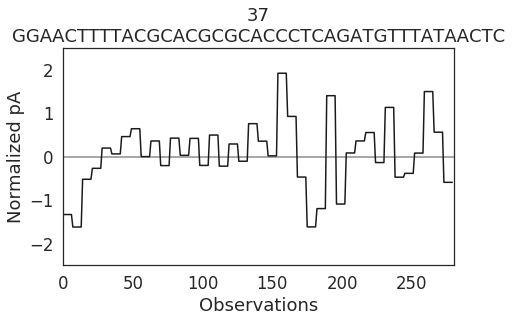

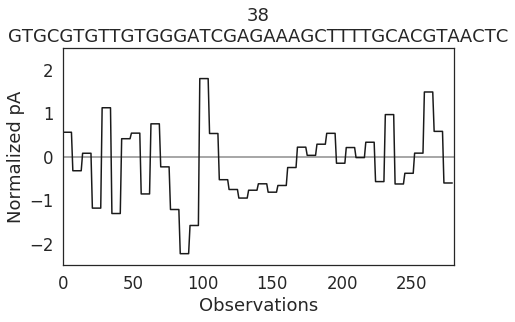

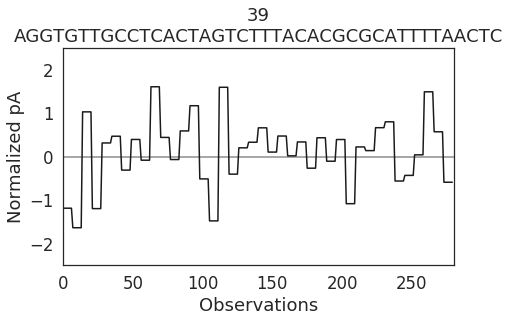

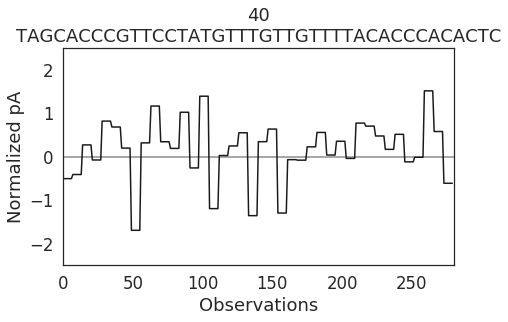

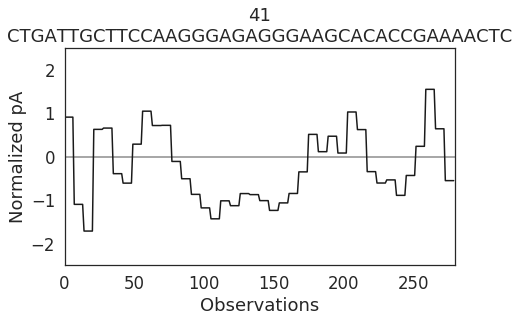

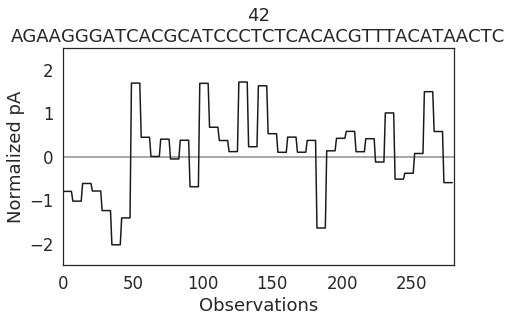

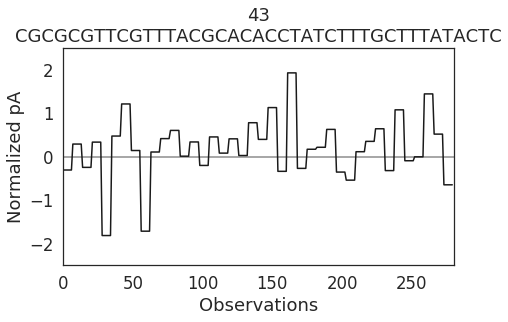

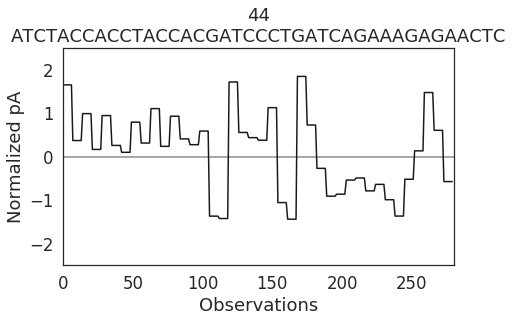

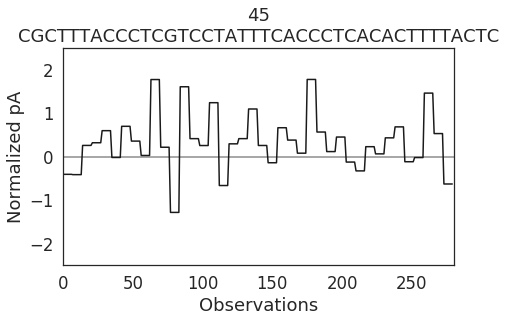

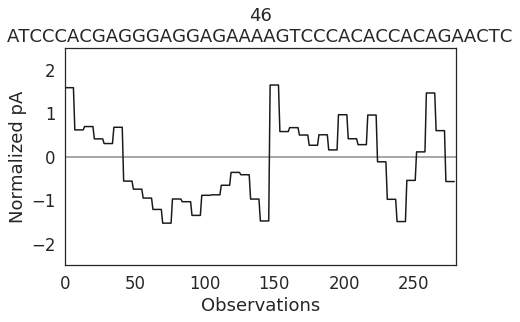

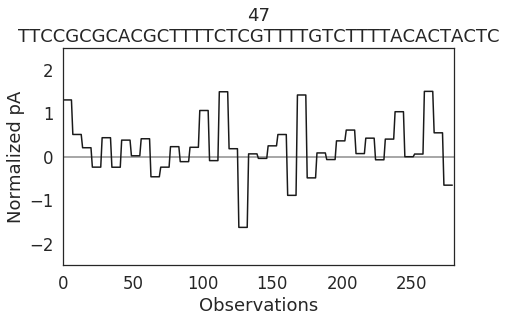

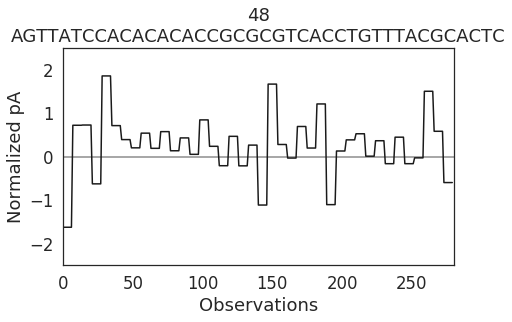

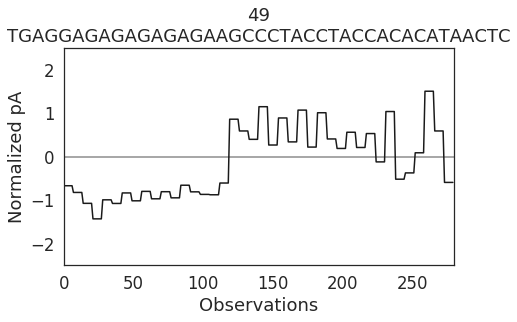

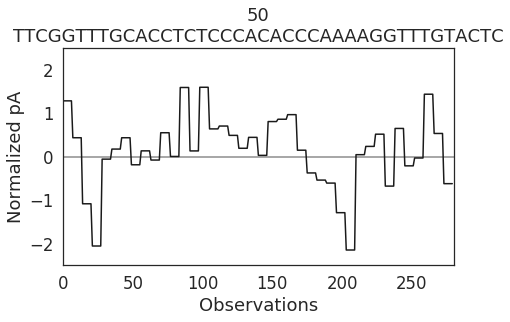

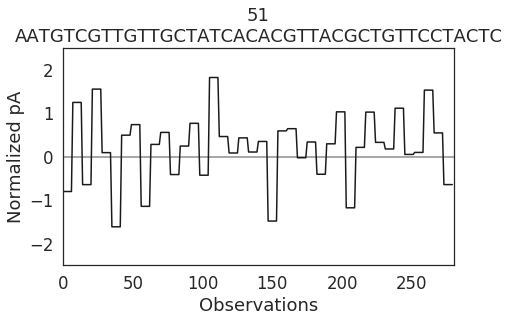

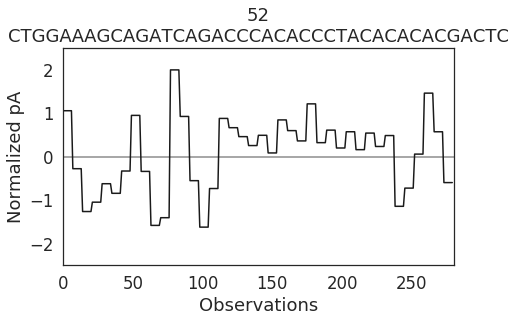

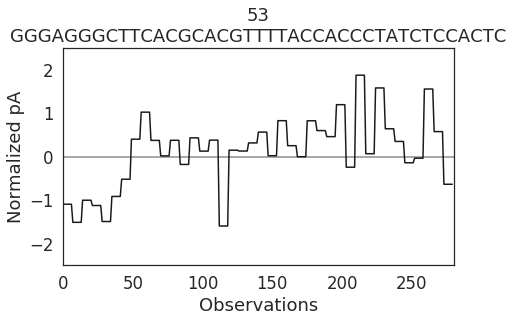

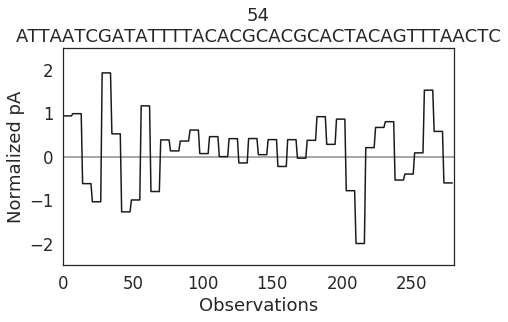

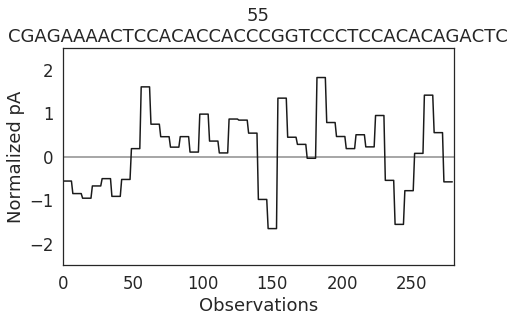

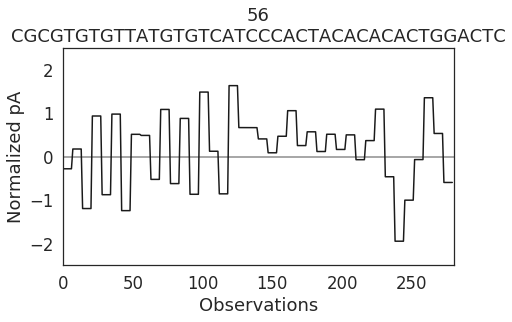

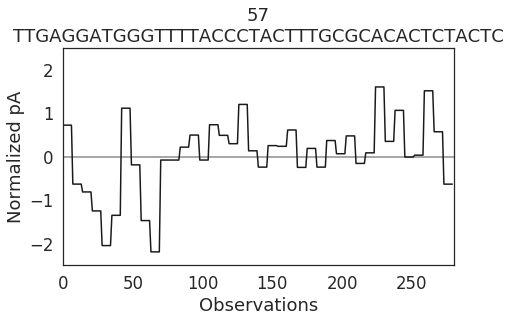

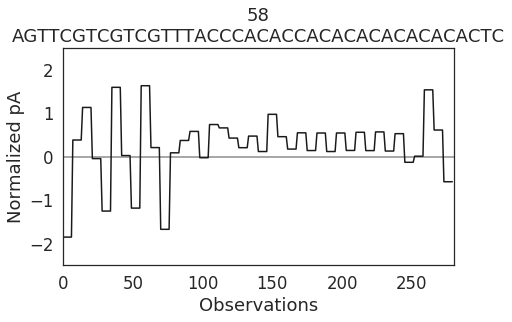

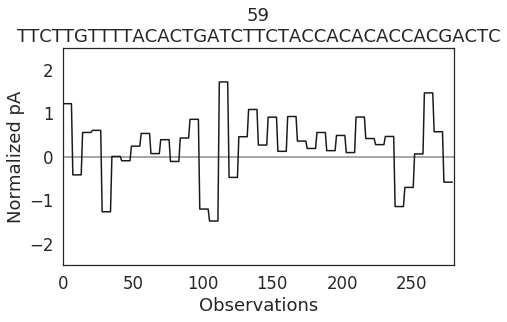

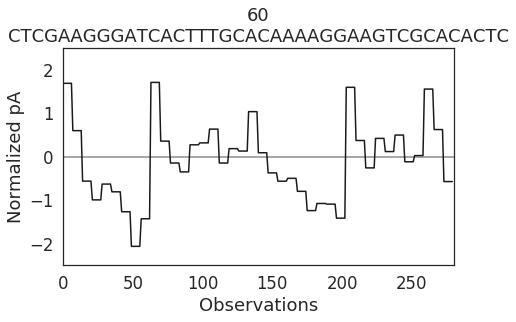

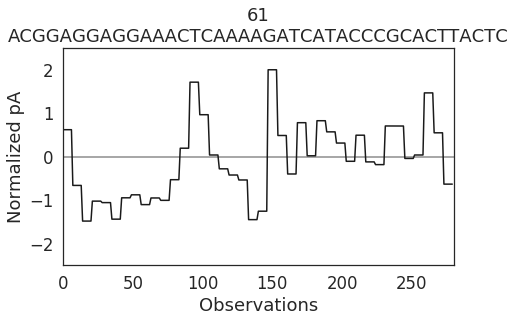

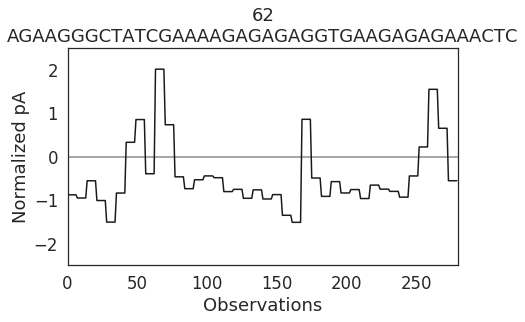

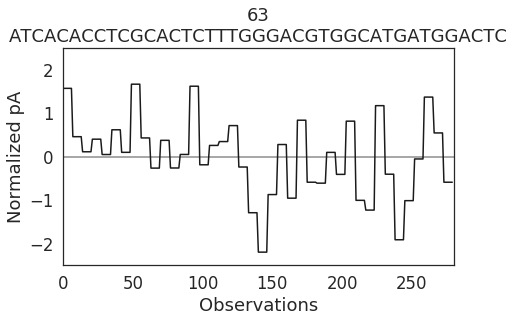

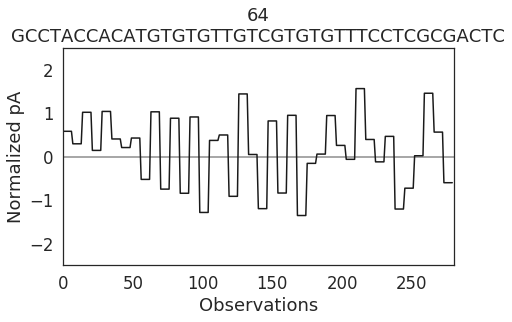

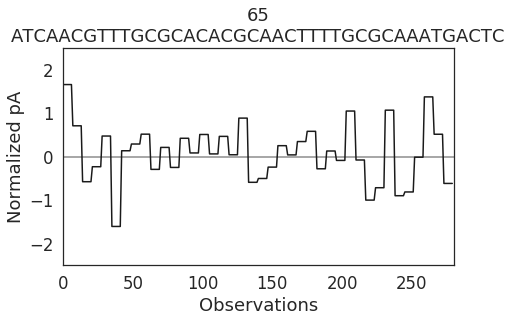

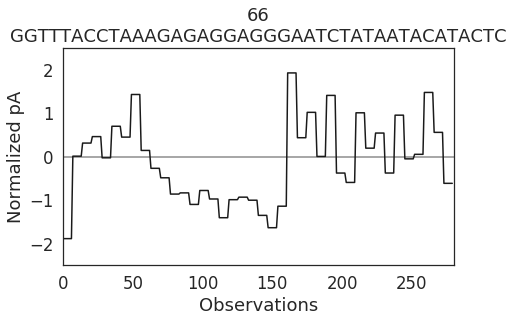

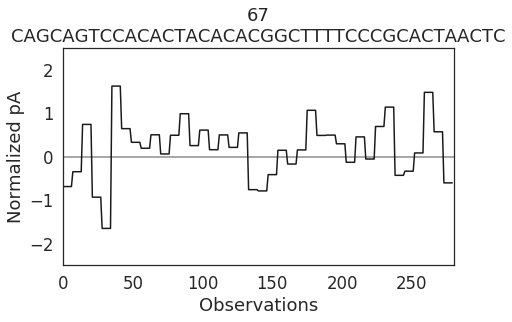

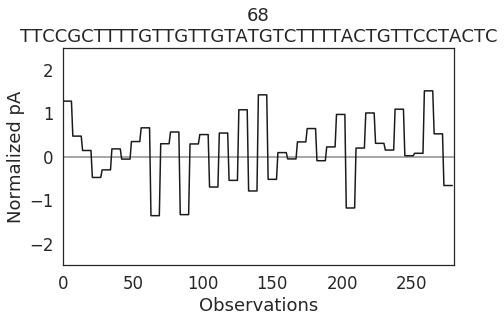

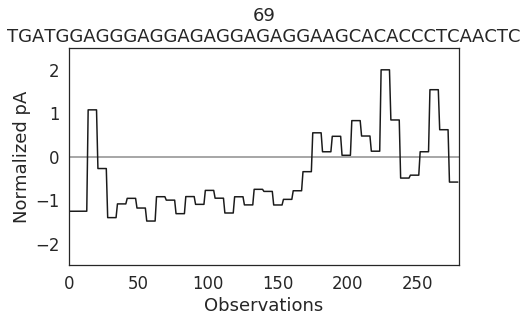

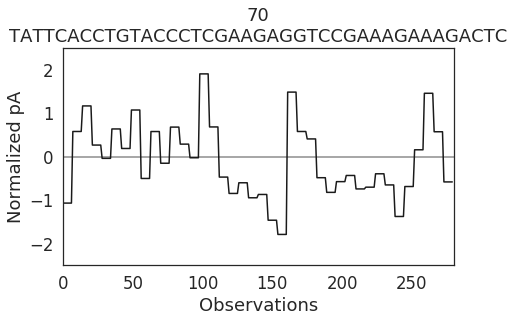

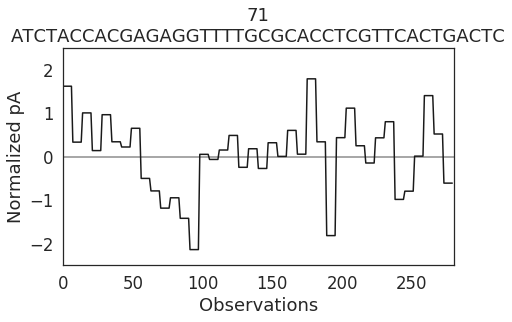

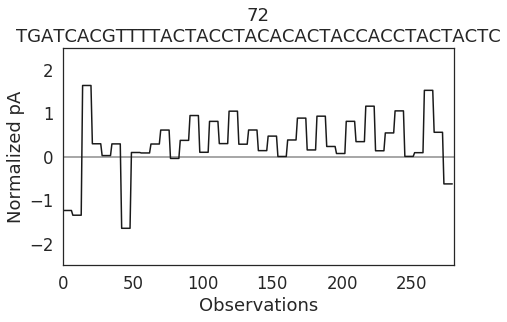

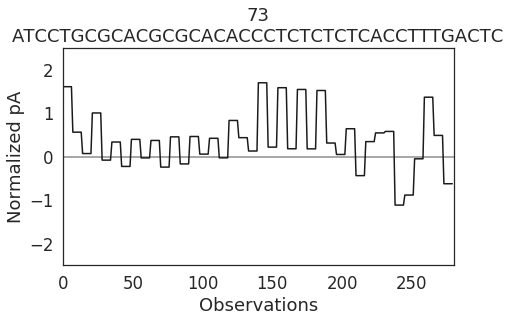

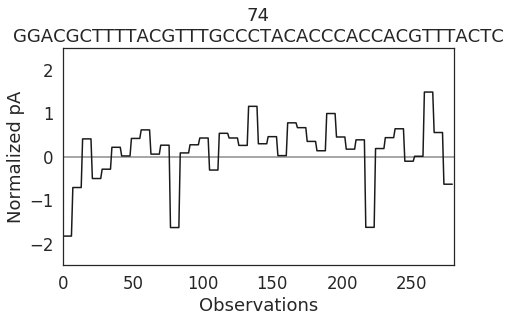

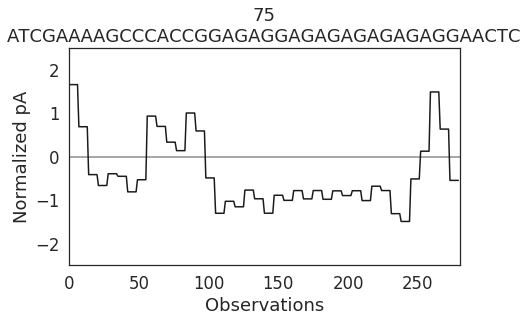

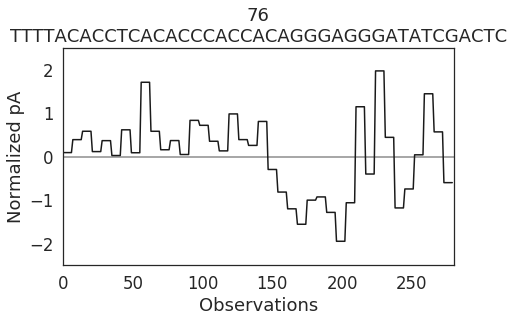

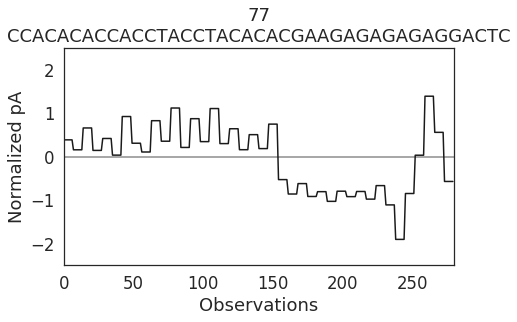

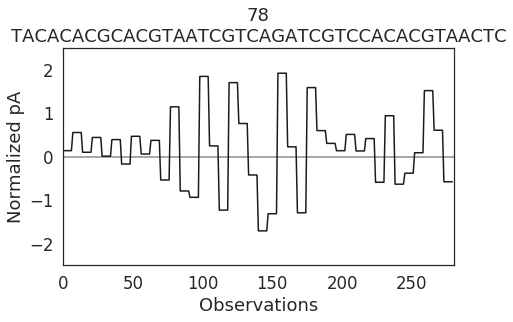

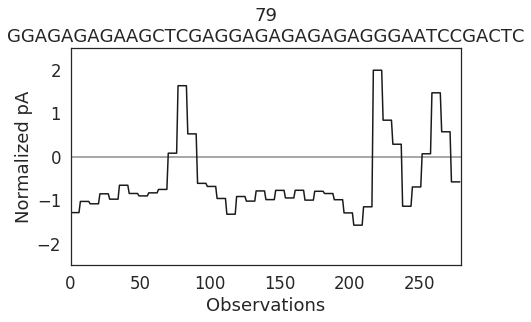

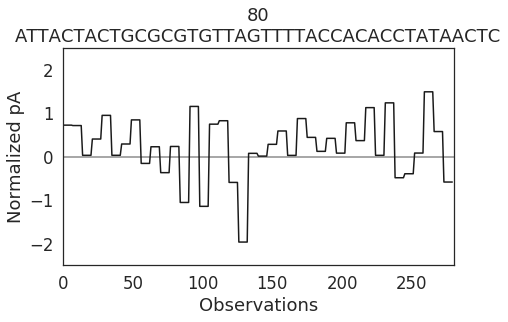

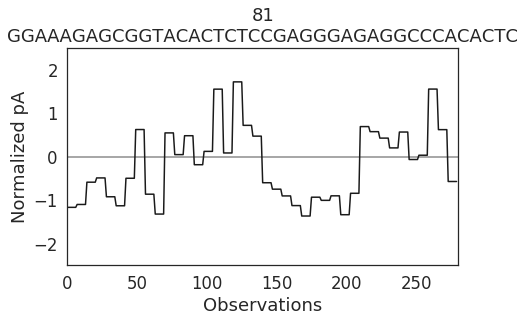

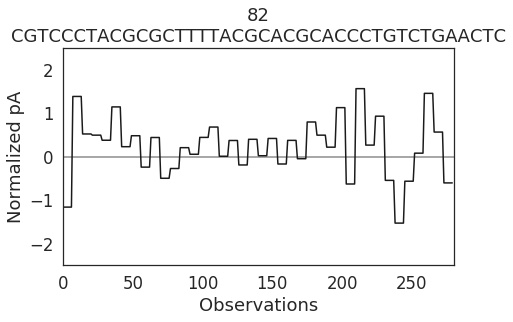

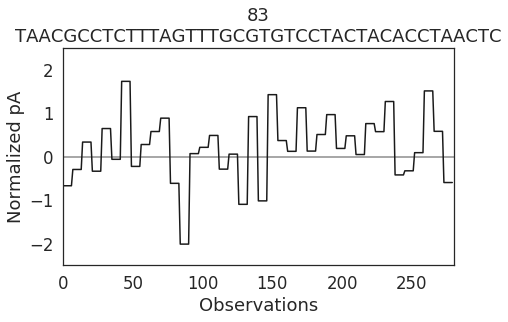

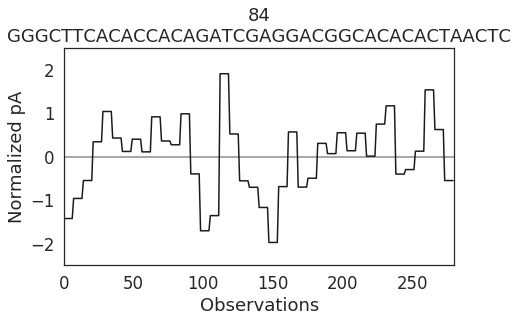

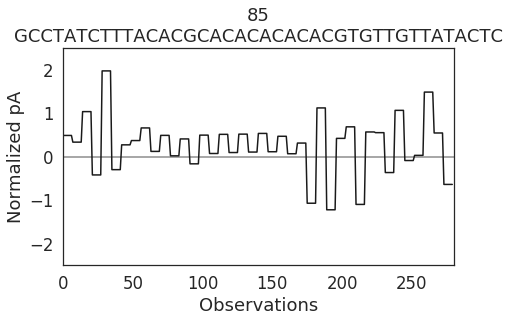

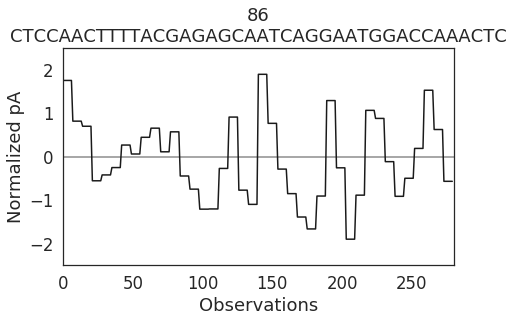

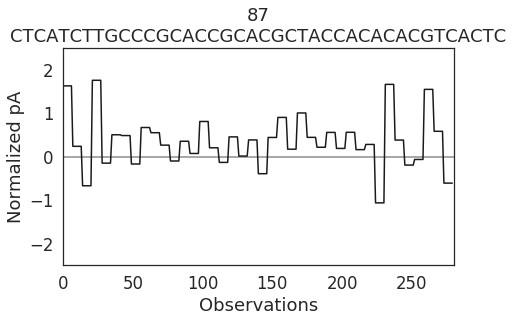

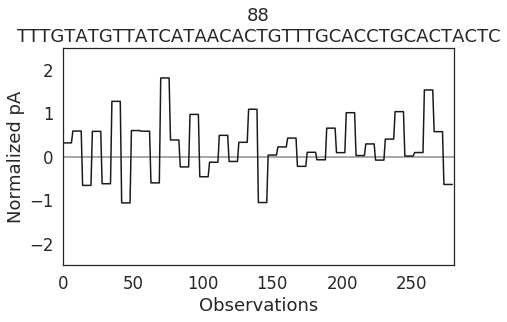

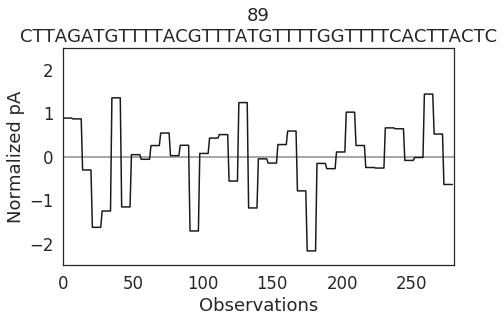

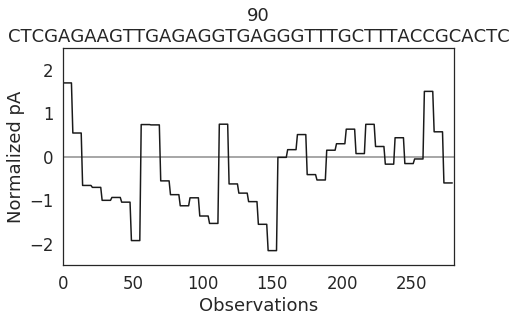

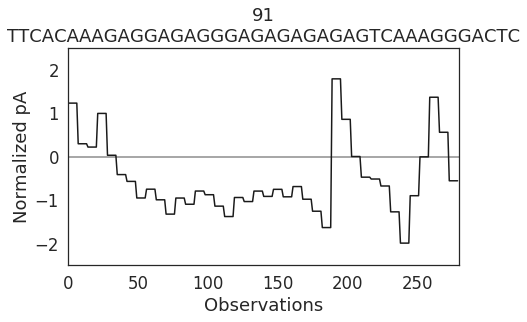

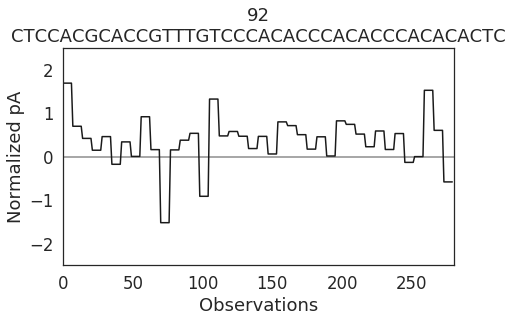

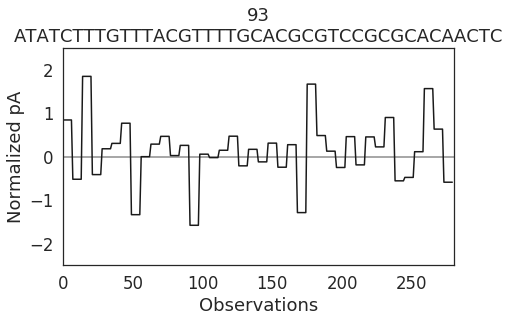

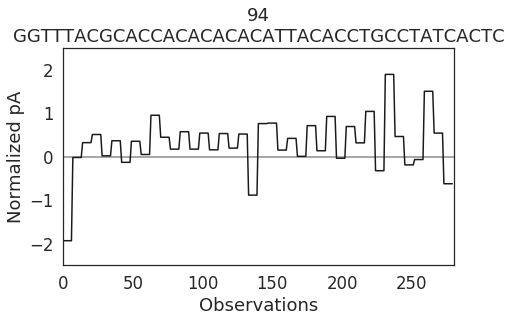

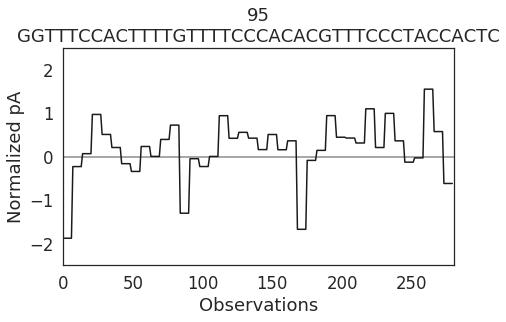

In [40]:
for i, df in enumerate(scrappie_dfs):
    fig, ax = plot_scrappie_squiggle(df, seq_name=str(i))
    plt.show()
    fig.savefig(f"../v4/plots/design/squiggle_plots/{i:2d}.svg")
    fig.savefig(f"../v4/plots/design/squiggle_plots/{i:2d}.png", dpi=300)

[[0.         7.02672625 4.98634863 6.76327181]
 [7.02672625 0.         6.7381134  4.45516396]
 [4.98634863 6.7381134  0.         7.35808134]
 [6.76327181 4.45516396 7.35808134 0.        ]]
[0.         7.02672625 4.98634863 6.76327181]
[7.02672625 0.         6.7381134  4.45516396]
[4.98634863 6.7381134  0.         7.35808134]


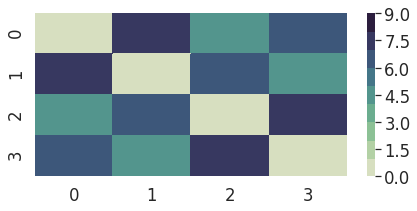

In [62]:
ix = np.array([1, 5, 6, 10])
dtw_1, dtw_5, dtw_6, dtw_10 = D_dtw[ix]
mini_dtw = np.vstack([dtw_1[ix], dtw_5[ix], dtw_6[ix], dtw_10[ix]])
print(mini_dtw)
print(dtw_1[ix])
print(dtw_5[ix])
print(dtw_6[ix])

cmap = sns.cubehelix_palette(9, start=.5, rot=-.75)
fig, ax = plt.subplots(figsize=(7, 3))
ax = sns.heatmap(mini_dtw, cmap=cmap, ax=ax, vmax=9)
fig.savefig("../v4/plots/design/sample_dtw_after.svg")

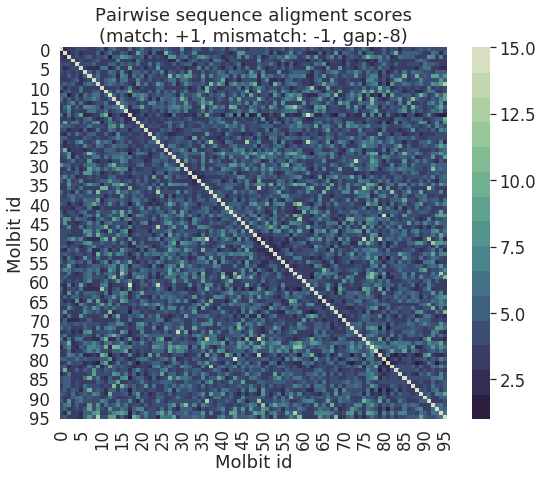

In [10]:
cmap = sns.cubehelix_palette(15, start=.5, rot=-.75)
fig, ax = plt.subplots(figsize=(8, 7))
ax = sns.heatmap(D_sw, cmap=cmap[::-1], vmax=15, ax=ax)#, cbar_ax=cbar_ax)
ax.set_xlabel("Molbit id")
ax.set_ylabel("Molbit id")
ax.set_title("Pairwise sequence aligment scores\n(match: +1, mismatch: -1, gap:-8)")
plt.tight_layout()
fig.savefig("../v4/plots/design/sw_heatmap.svg")
fig.savefig("../v4/plots/design/sw_heatmap.png", dpi=300)

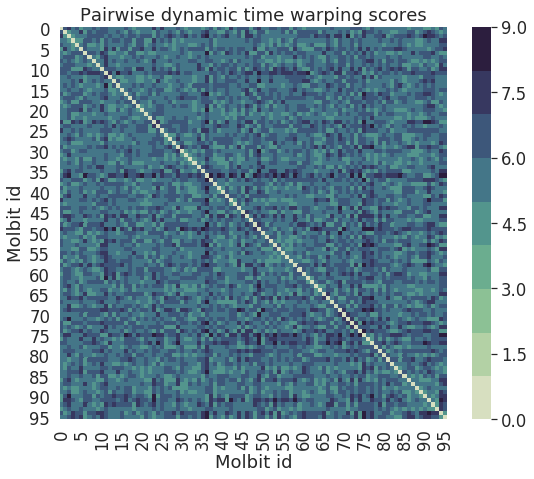

In [11]:
cmap = sns.cubehelix_palette(9, start=.5, rot=-.75)
fig, ax = plt.subplots(figsize=(8, 7))
ax = sns.heatmap(D_dtw, cmap=cmap, ax=ax, vmax=9)
ax.set_xlabel("Molbit id")
ax.set_ylabel("Molbit id")
ax.set_title("Pairwise dynamic time warping scores")
plt.tight_layout()
fig.savefig("../v4/plots/design/dtw_heatmap.svg")
fig.savefig("../v4/plots/design/dtw_heatmap.png", dpi=300)

In [12]:
triu = np.triu_indices(n=len(sequences), k=1)

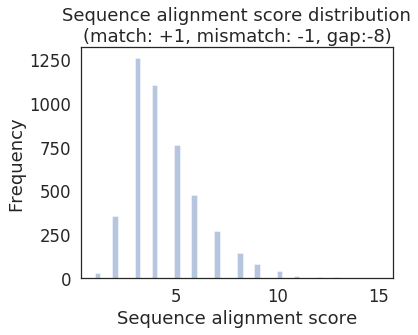

In [13]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.distplot(D_sw[triu], kde=False)
ax.set_xlabel("Sequence alignment score")
ax.set_ylabel("Frequency")
ax.set_title("Sequence alignment score distribution\n(match: +1, mismatch: -1, gap:-8)")
plt.tight_layout()
fig.savefig("../v4/plots/design/sw_distribution_all.svg")
fig.savefig("../v4/plots/design/sw_distribution_all.png", dpi=300)

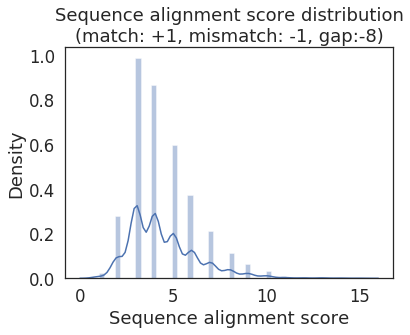

In [14]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.distplot(D_sw[triu])
ax.set_xlabel("Sequence alignment score")
ax.set_ylabel("Density")
ax.set_title("Sequence alignment score distribution\n(match: +1, mismatch: -1, gap:-8)")
plt.tight_layout()
fig.savefig("../v4/plots/design/sw_distribution_all_density.svg")
fig.savefig("../v4/plots/design/sw_distribution_all_density.png", dpi=300)

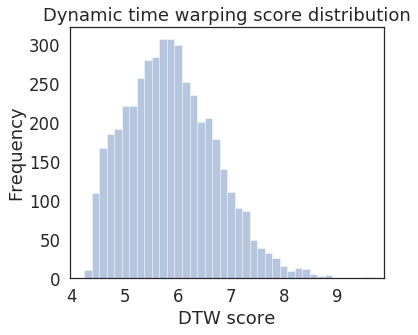

In [15]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.distplot(D_dtw[triu], kde=False)
ax.set_xlabel("DTW score")
ax.set_ylabel("Frequency")
ax.set_title("Dynamic time warping score distribution")
plt.tight_layout()
fig.savefig("../v4/plots/design/dtw_distribution_all.svg")
fig.savefig("../v4/plots/design/dtw_distribution_all.png", dpi=300)

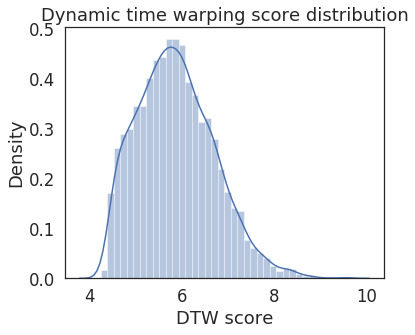

In [16]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.distplot(D_dtw[triu])
ax.set_xlabel("DTW score")
ax.set_ylabel("Density")
ax.set_title("Dynamic time warping score distribution")
plt.tight_layout()
fig.savefig("../v4/plots/design/dtw_distribution_all_density.svg")
fig.savefig("../v4/plots/design/dtw_distribution_all_density.png", dpi=300)

In [17]:
np.mean(D_dtw[triu]), np.std(D_dtw[triu]), np.mean(D_sw[triu]), np.std(D_sw[triu])

(5.870012515260462, 0.8332790411578422, 4.437061403508772, 1.835680512398067)

In [18]:
np.min(D_dtw[triu]), np.max(D_sw[triu])

(4.242717266082764, 15.0)

# Starting seqs

In [63]:
seq_file = "../headers/sequences_v4_test_starters.fa"
sequences = []
with open(seq_file, "r") as f:
    for line in f:
        if line.startswith(">"):
            continue
        else:
            sequences.append(line.strip())
assert len(sequences) == 96


In [64]:
D_dtw, D_sw, scrappie_dfs = initialize_distance(sequences)

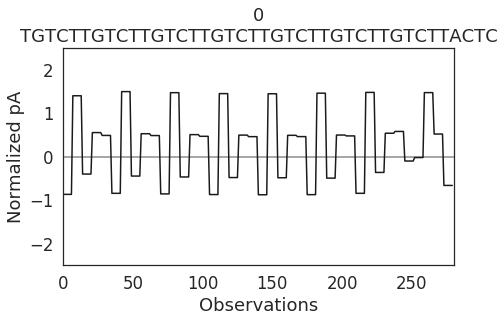

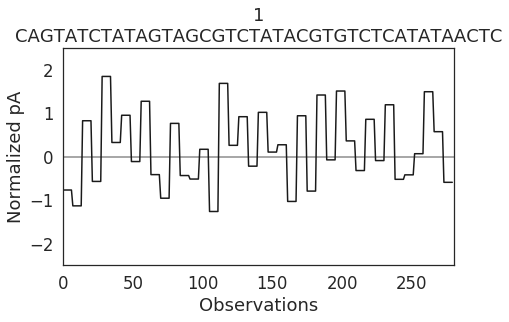

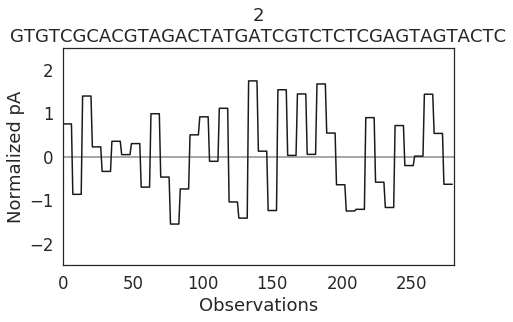

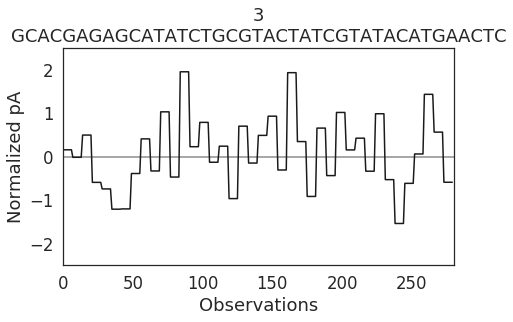

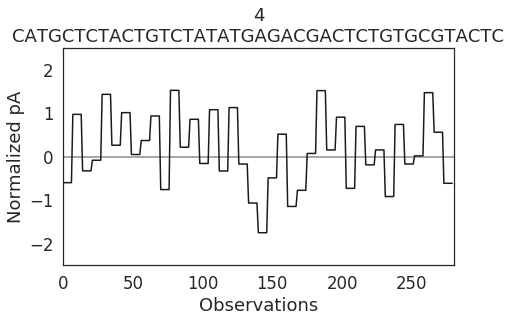

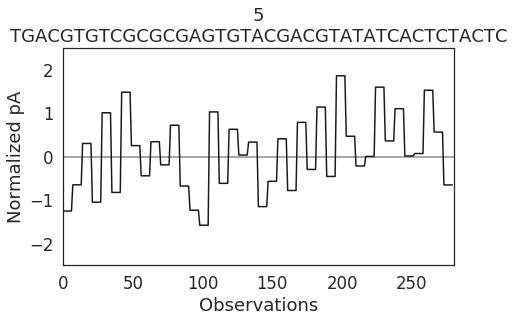

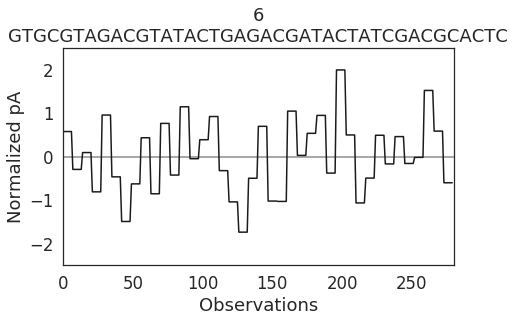

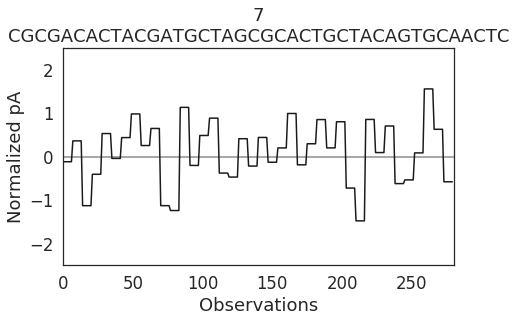

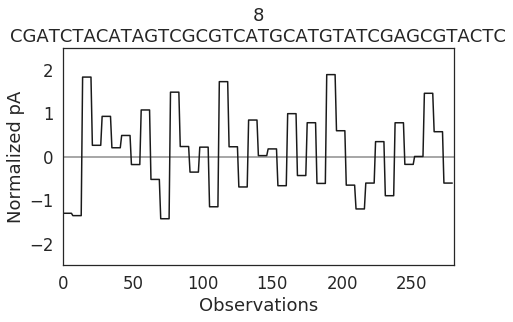

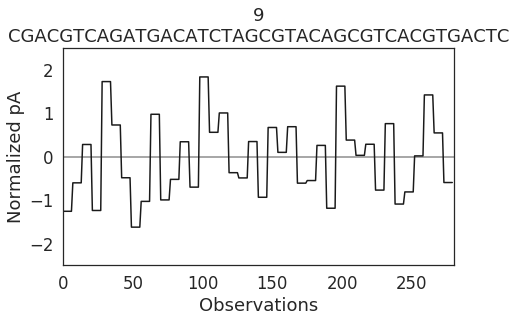

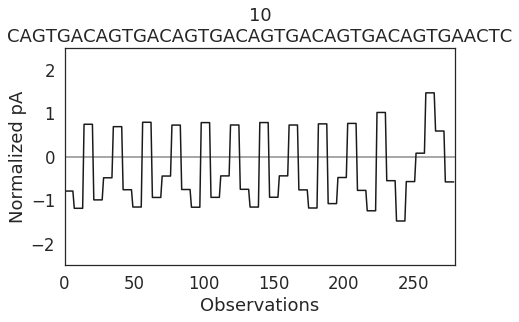

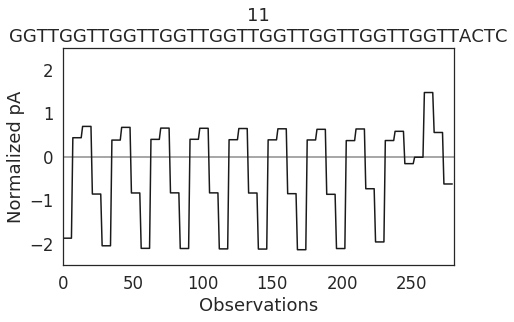

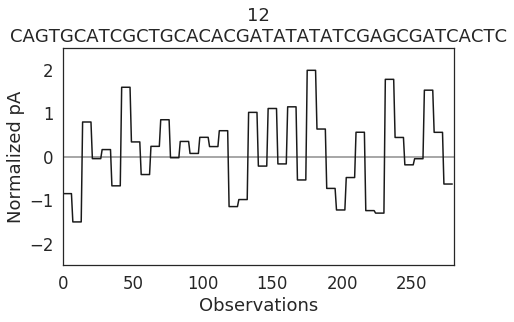

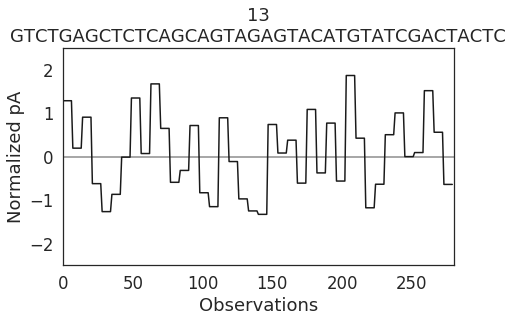

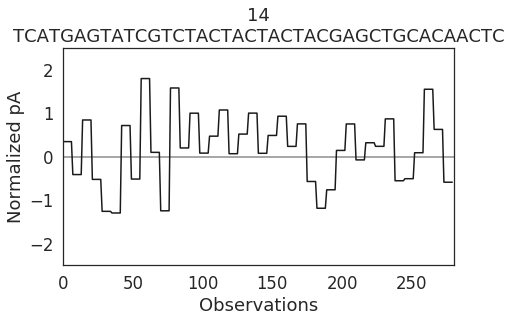

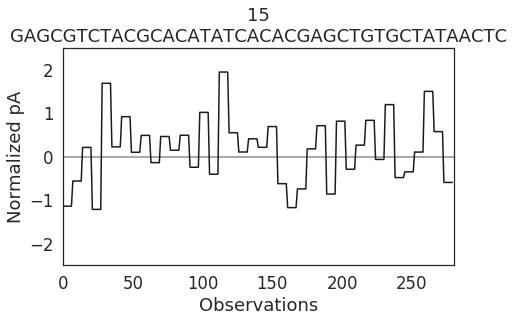

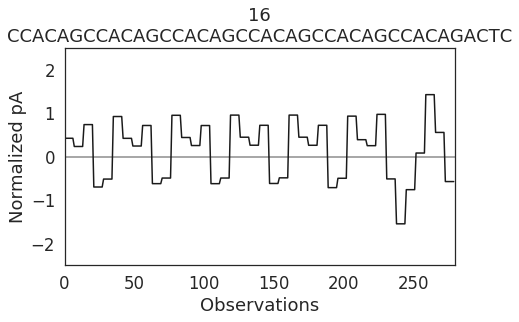

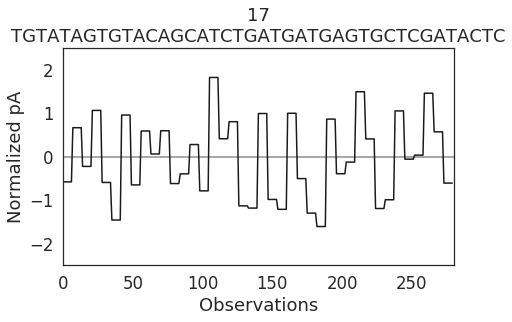

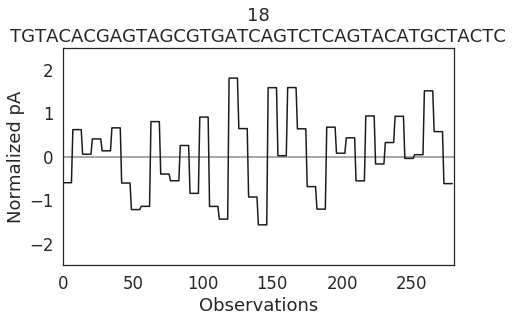

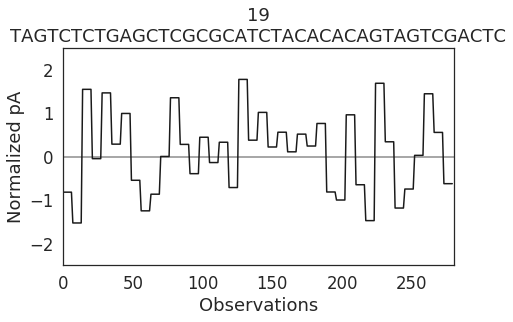

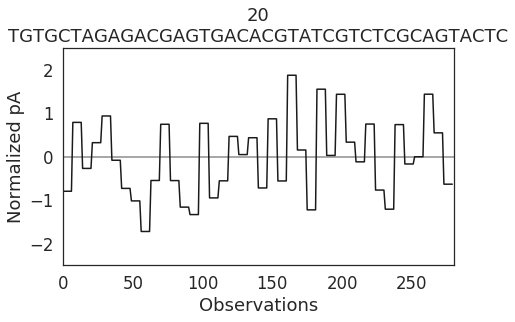

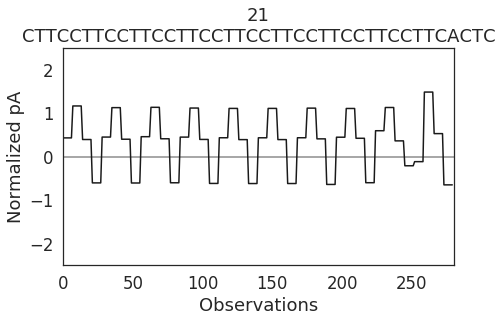

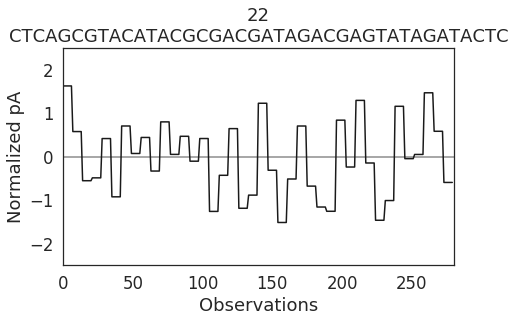

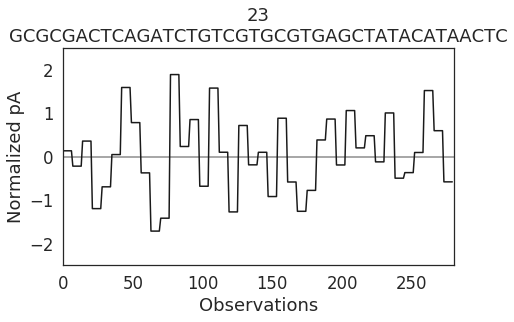

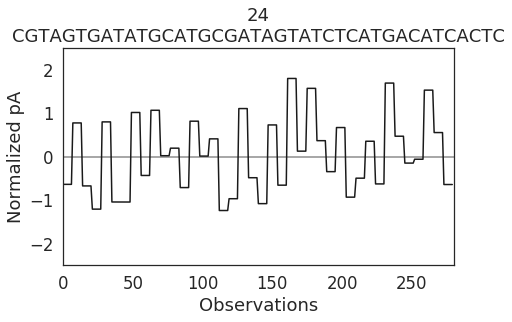

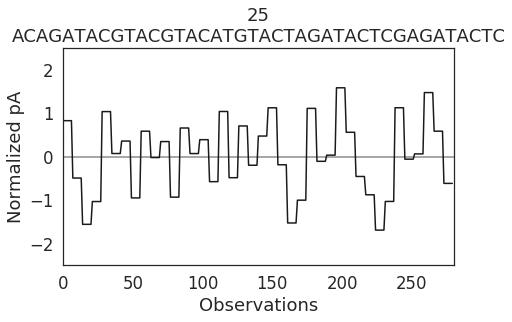

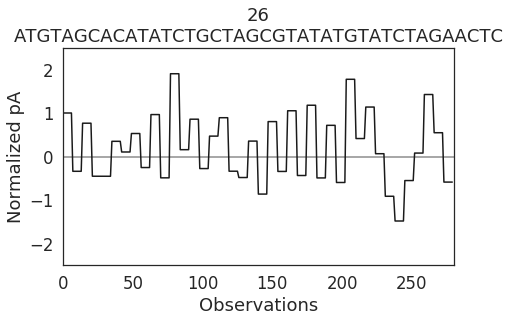

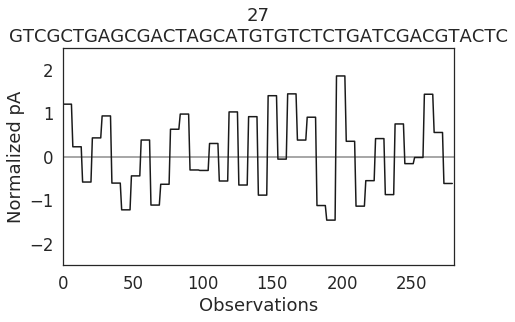

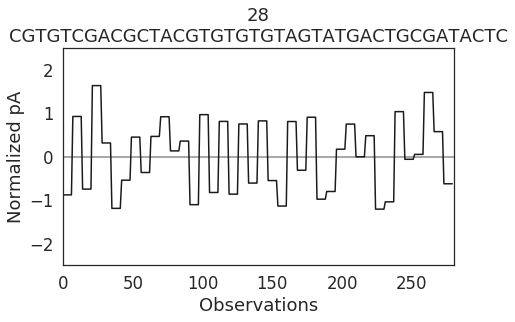

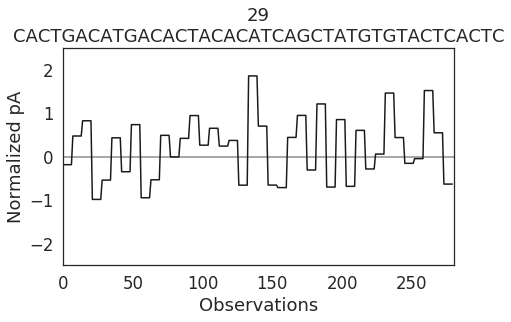

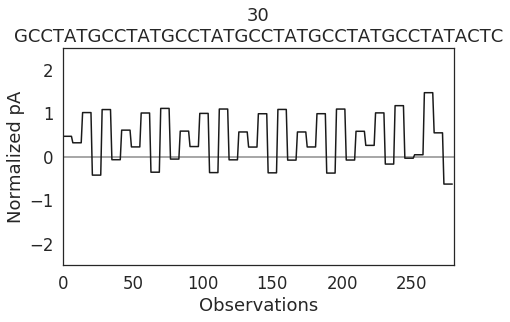

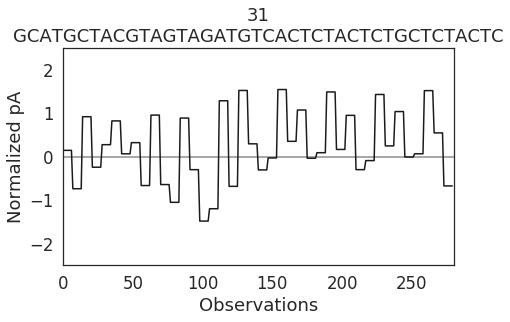

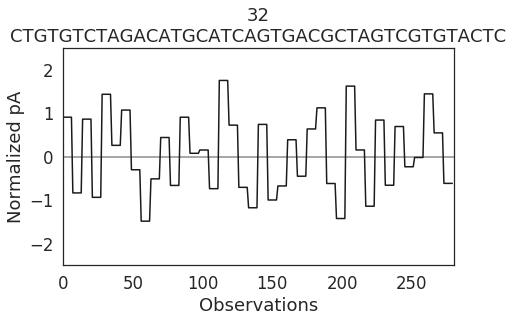

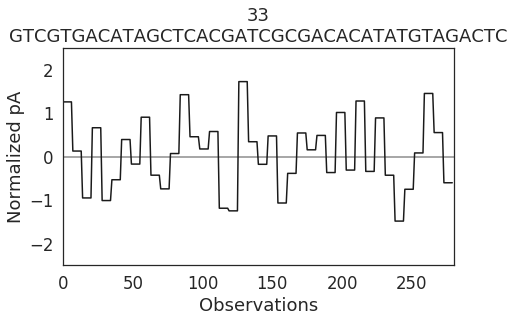

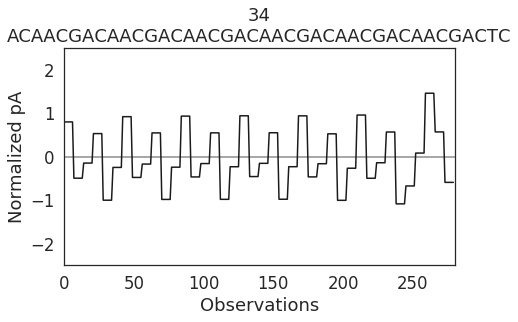

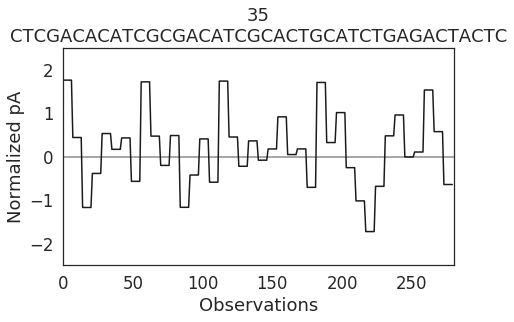

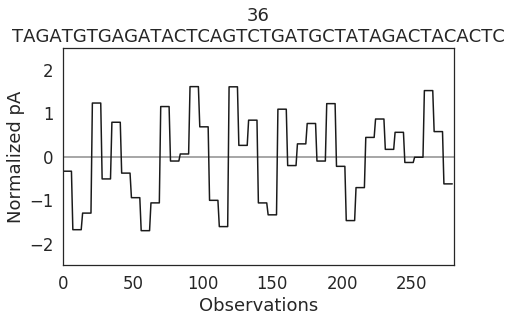

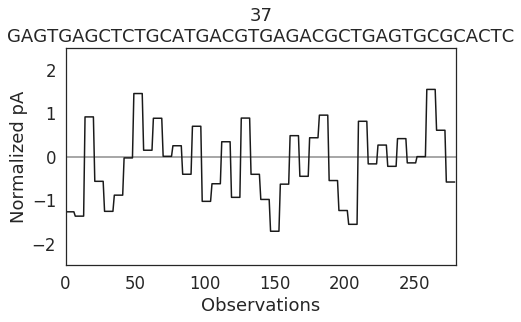

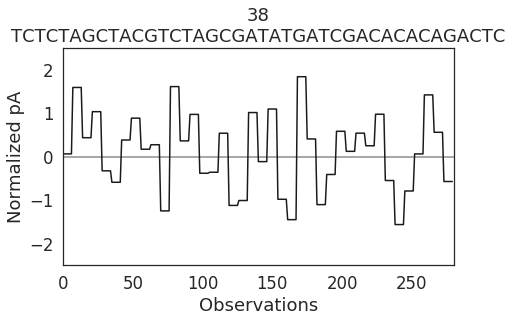

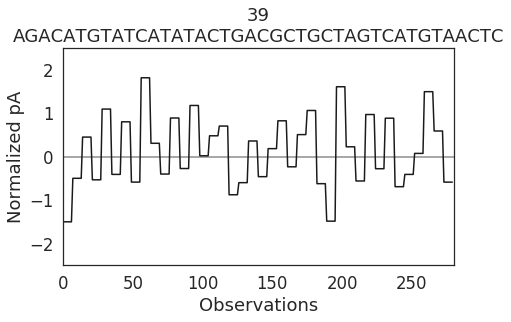

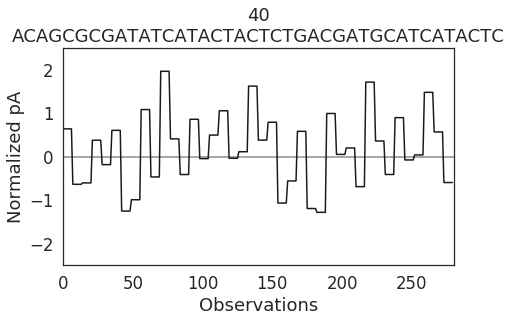

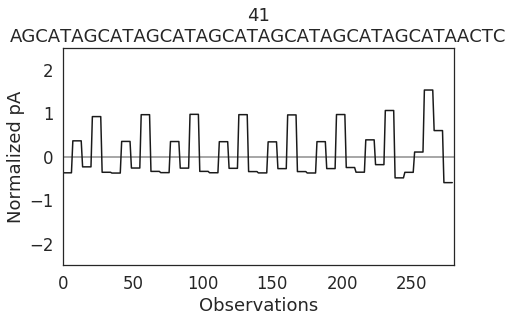

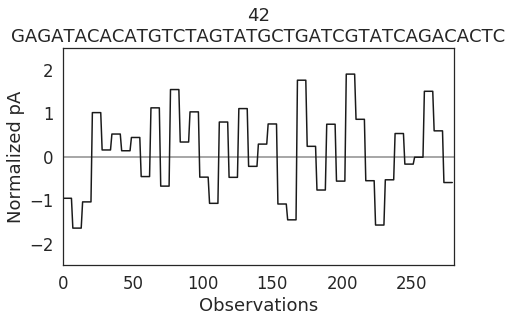

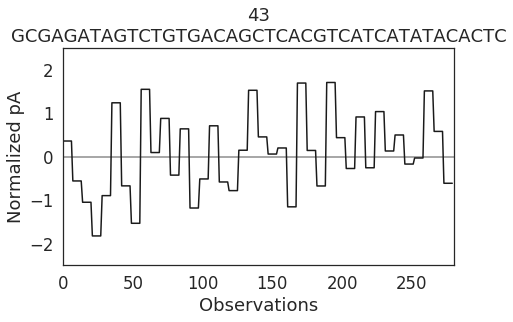

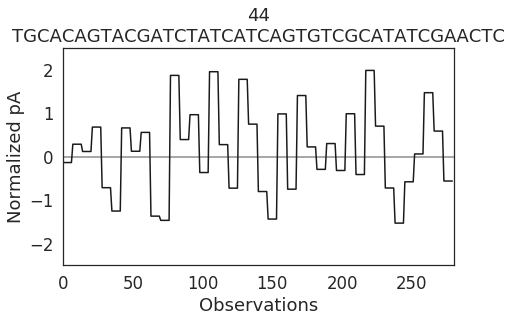

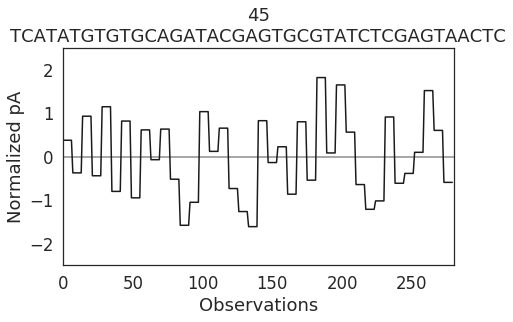

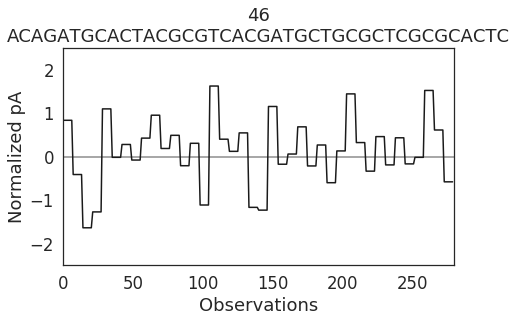

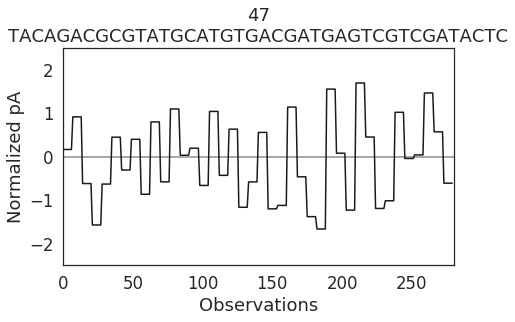

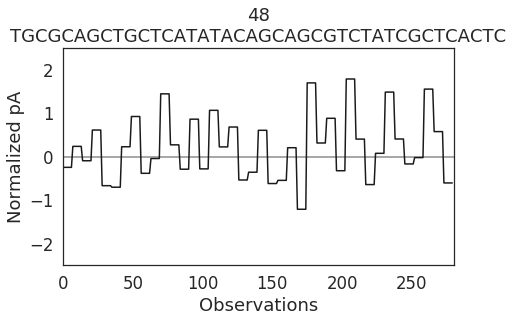

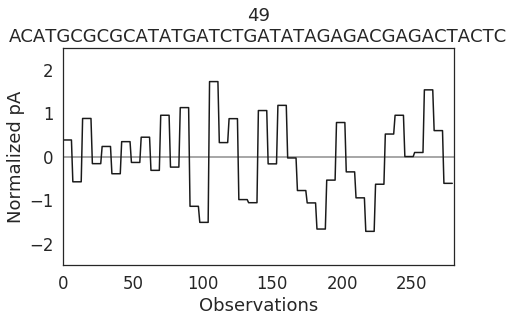

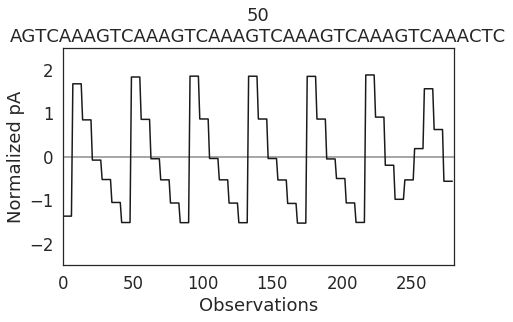

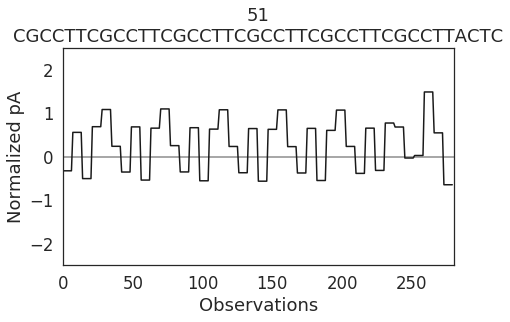

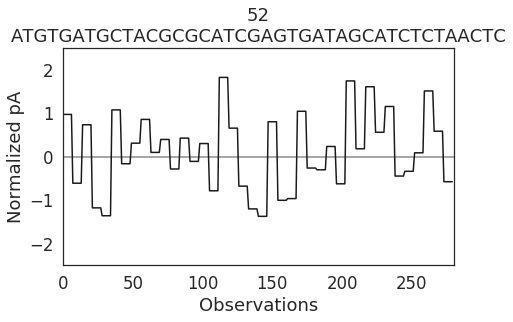

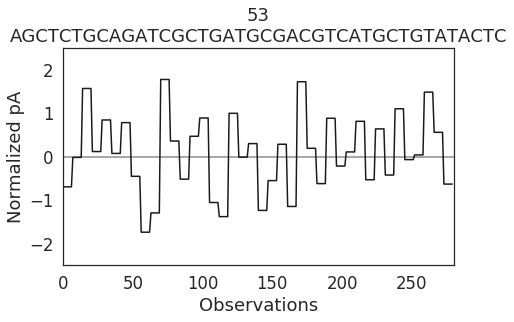

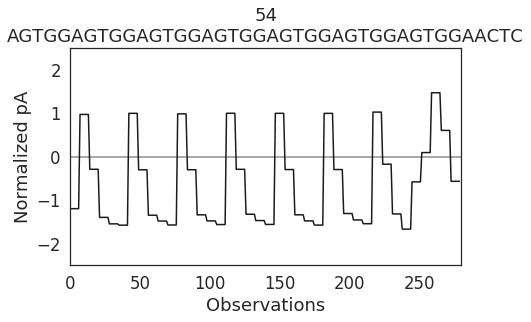

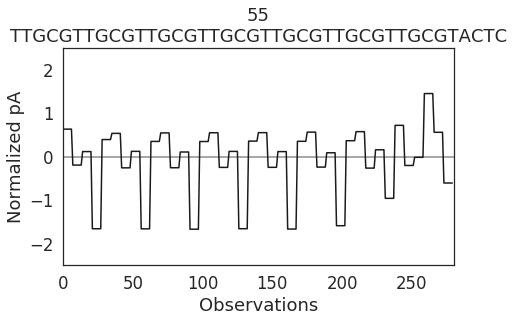

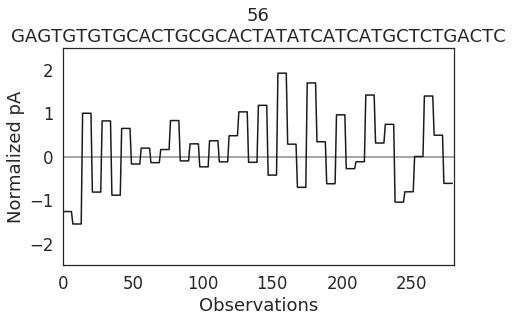

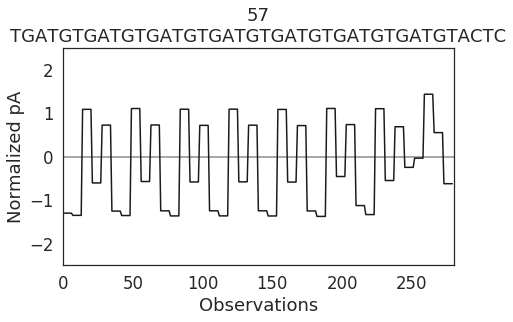

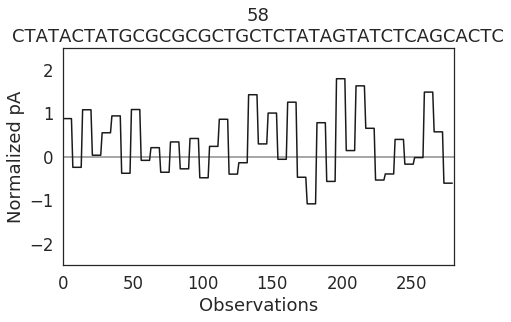

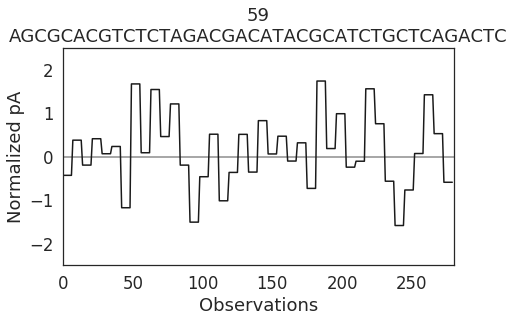

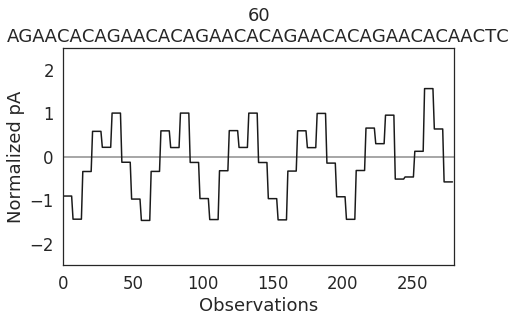

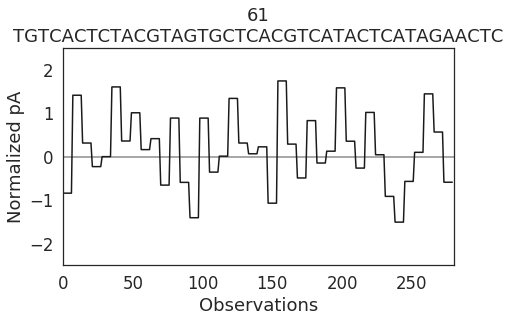

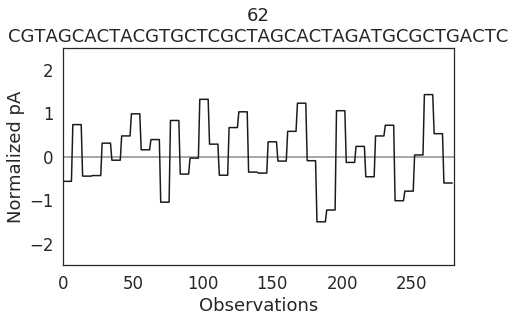

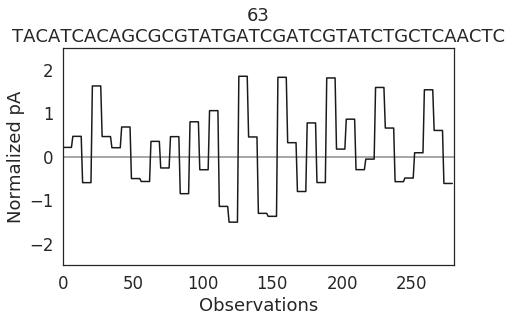

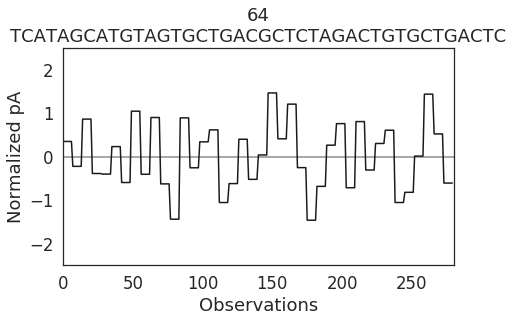

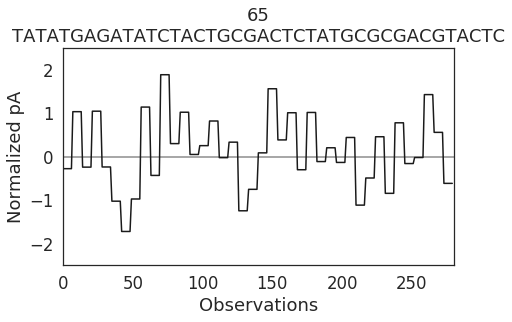

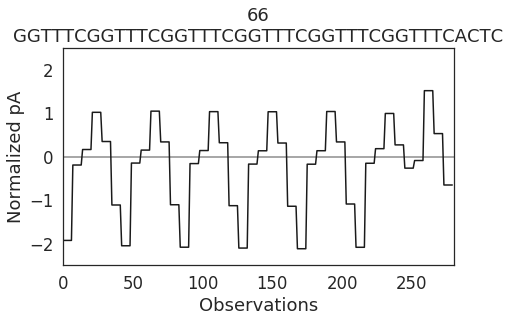

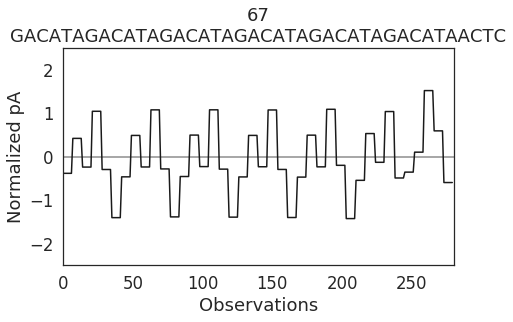

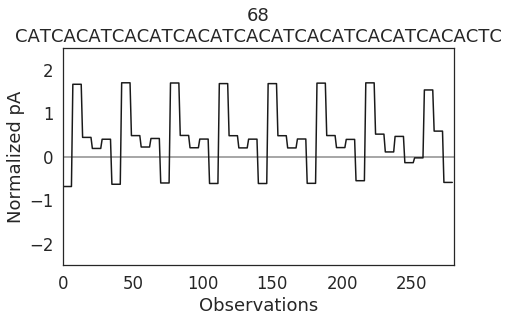

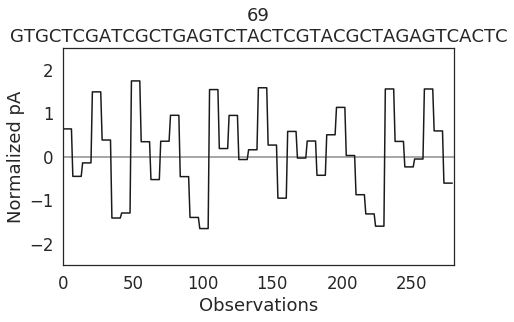

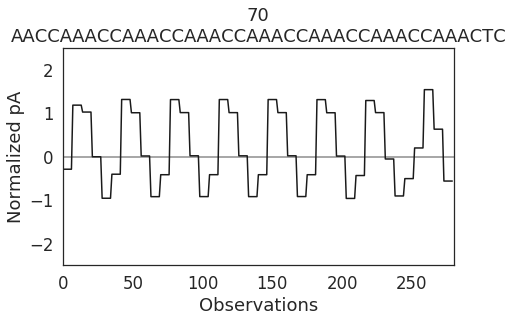

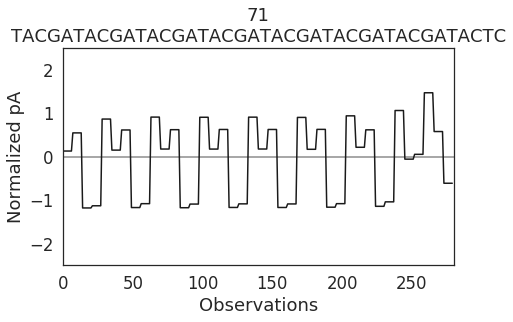

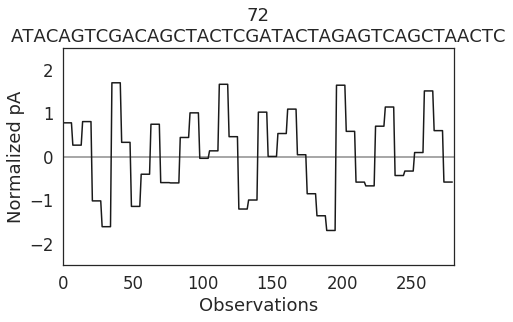

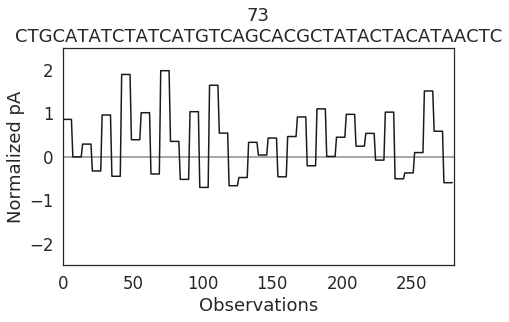

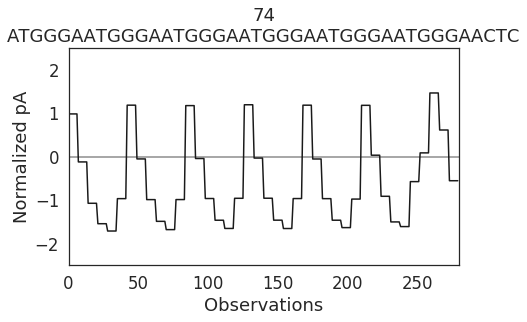

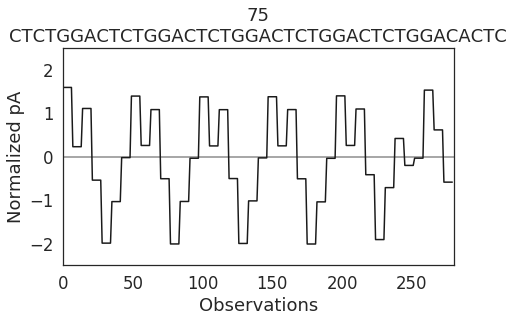

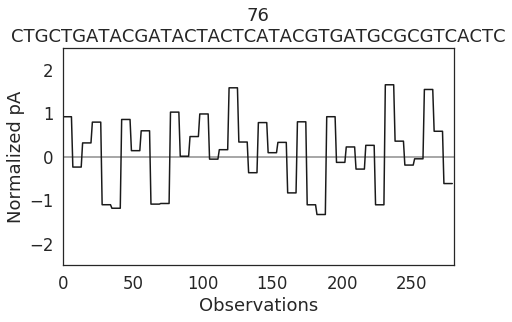

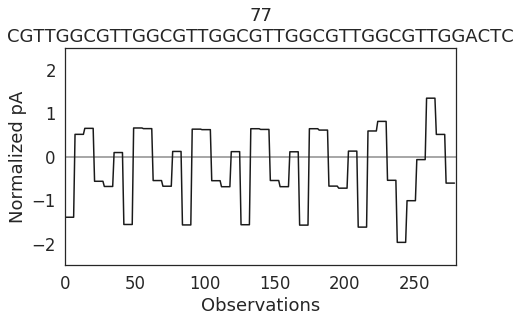

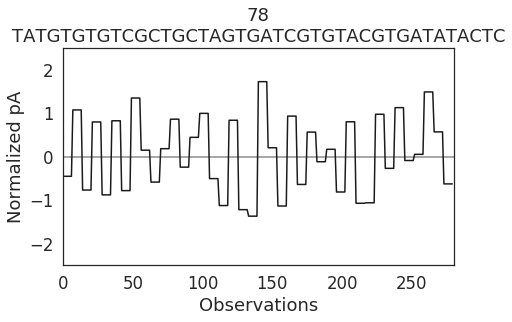

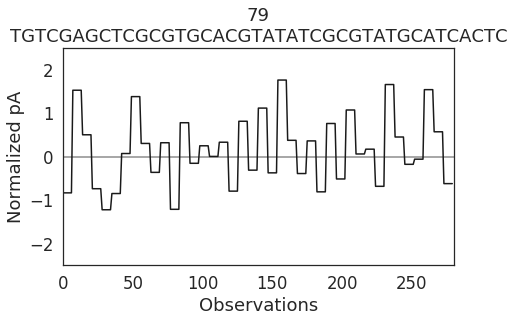

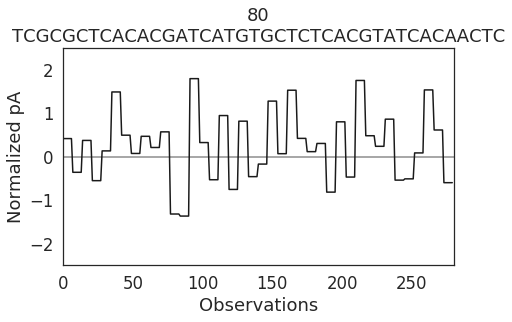

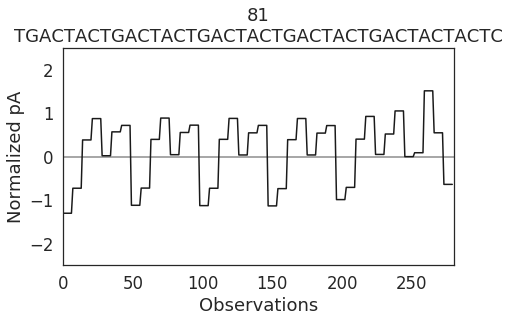

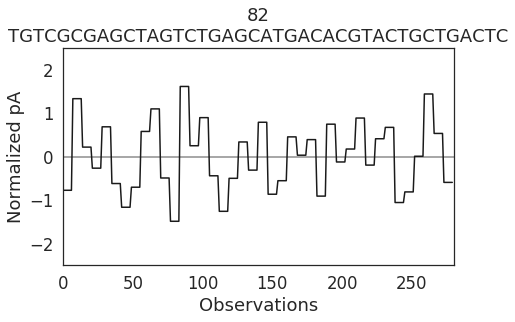

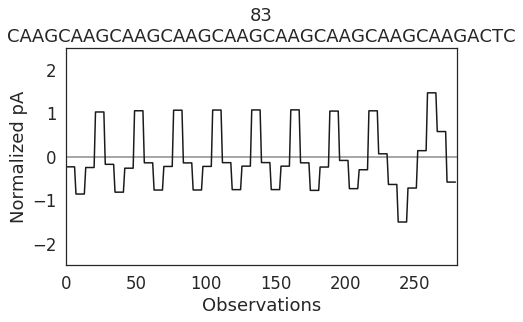

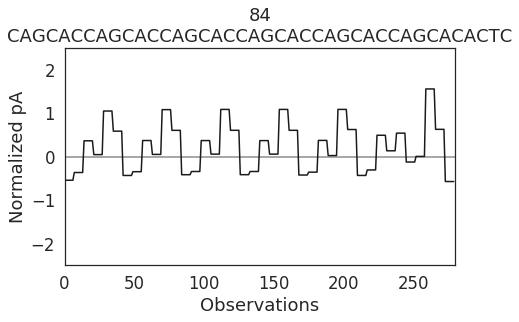

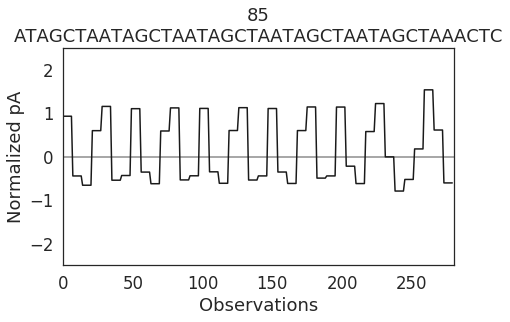

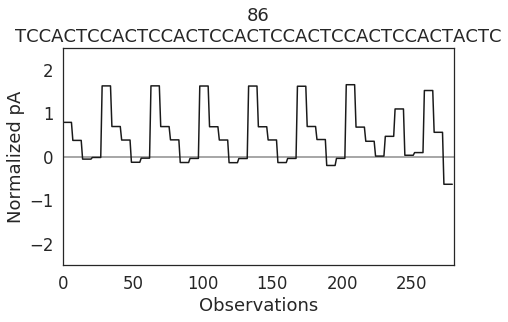

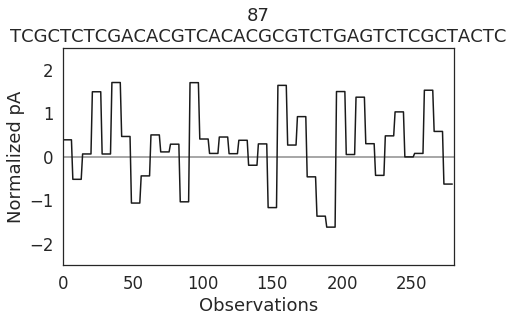

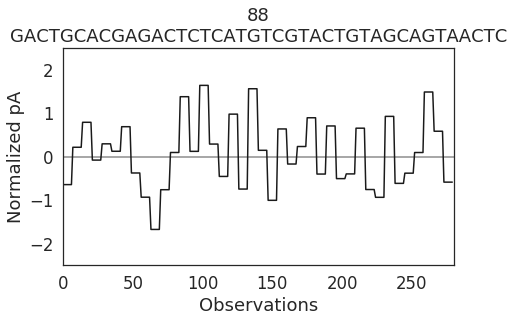

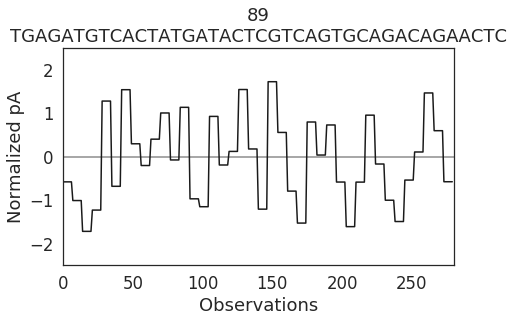

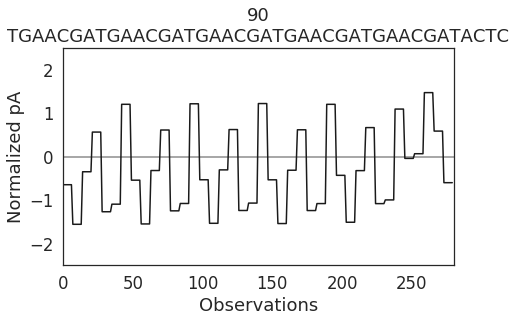

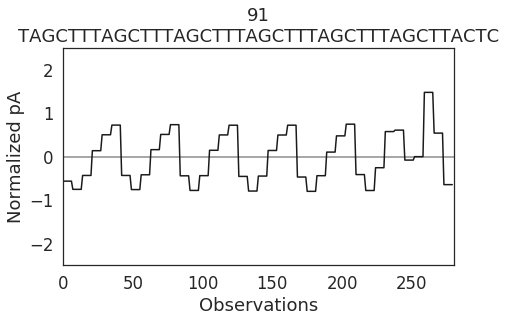

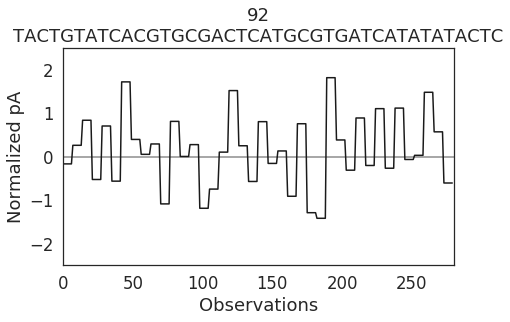

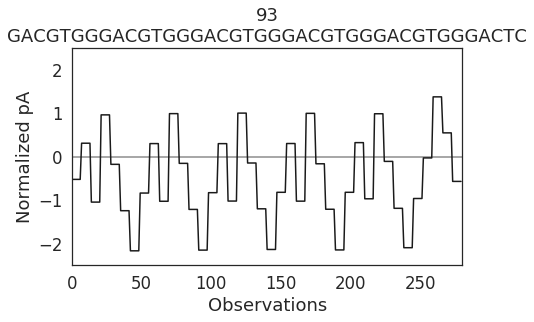

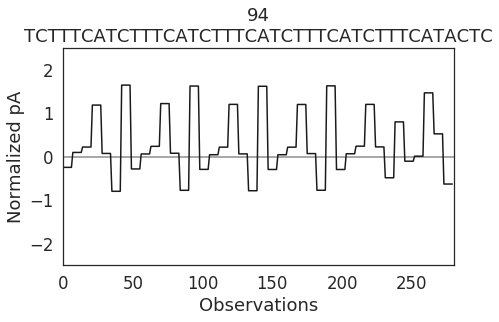

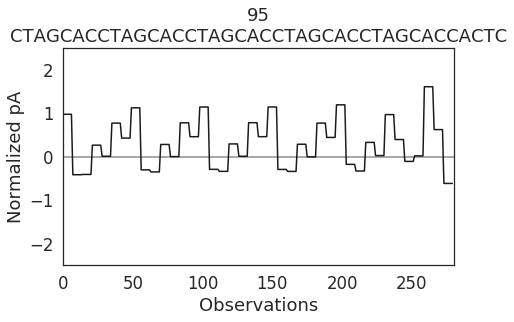

In [65]:
for i, df in enumerate(scrappie_dfs):
    fig, ax = plot_scrappie_squiggle(df, seq_name=str(i))
    plt.show()
    fig.savefig(f"../v4/plots/design/squiggle_plots_starterseqs/{i:2d}.svg")
    fig.savefig(f"../v4/plots/design/squiggle_plots_starterseqs/{i:2d}.png", dpi=300)

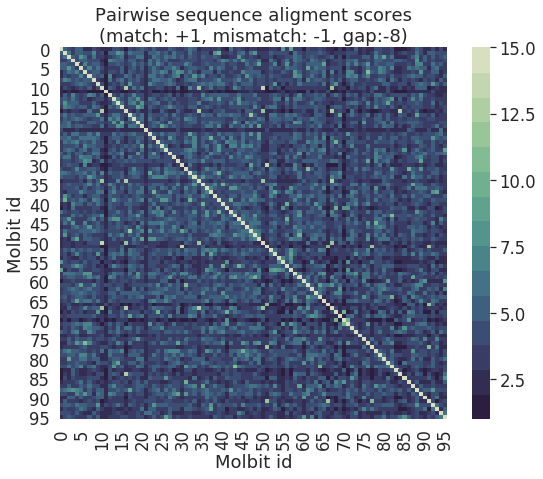

In [22]:
cmap = sns.cubehelix_palette(15, start=.5, rot=-.75)
fig, ax = plt.subplots(figsize=(8, 7))
ax = sns.heatmap(D_sw, cmap=cmap[::-1], vmax=15, ax=ax)#, cbar_ax=cbar_ax)
ax.set_xlabel("Molbit id")
ax.set_ylabel("Molbit id")
ax.set_title("Pairwise sequence aligment scores\n(match: +1, mismatch: -1, gap:-8)")
plt.tight_layout()
fig.savefig("../v4/plots/design/sw_heatmap_starterseqs.svg")
fig.savefig("../v4/plots/design/sw_heatmap_starterseqs.png", dpi=300)

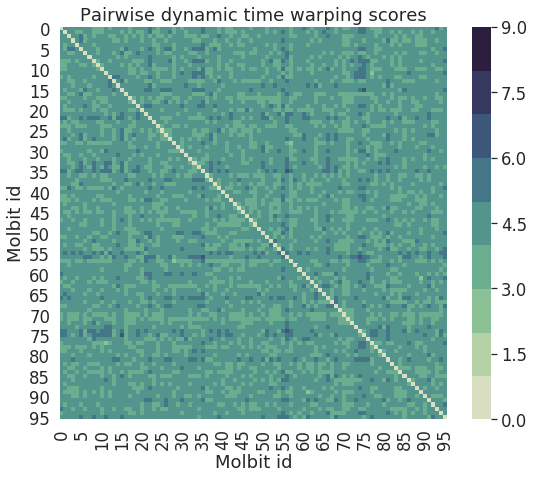

In [23]:
cmap = sns.cubehelix_palette(9, start=.5, rot=-.75)
fig, ax = plt.subplots(figsize=(8, 7))
ax = sns.heatmap(D_dtw, cmap=cmap, ax=ax, vmax=9)
ax.set_xlabel("Molbit id")
ax.set_ylabel("Molbit id")
ax.set_title("Pairwise dynamic time warping scores")
plt.tight_layout()
fig.savefig("../v4/plots/design/dtw_heatmap_starterseqs.svg")
fig.savefig("../v4/plots/design/dtw_heatmap_starterseqs.png", dpi=300)

In [24]:
triu = np.triu_indices(n=len(sequences), k=1)

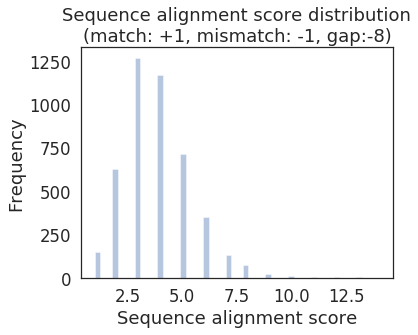

In [25]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.distplot(D_sw[triu], kde=False)
ax.set_xlabel("Sequence alignment score")
ax.set_ylabel("Frequency")
ax.set_title("Sequence alignment score distribution\n(match: +1, mismatch: -1, gap:-8)")
plt.tight_layout()
fig.savefig("../v4/plots/design/sw_distribution_all_starterseqs.svg")
fig.savefig("../v4/plots/design/sw_distribution_all_starterseqs.png", dpi=300)

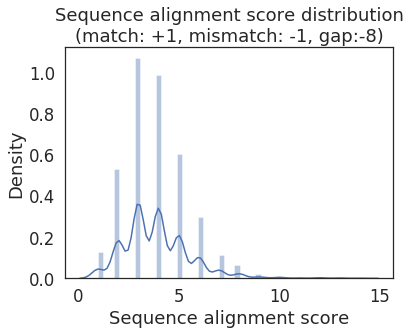

In [26]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.distplot(D_sw[triu])
ax.set_xlabel("Sequence alignment score")
ax.set_ylabel("Density")
ax.set_title("Sequence alignment score distribution\n(match: +1, mismatch: -1, gap:-8)")
plt.tight_layout()
fig.savefig("../v4/plots/design/sw_distribution_all_density_starterseqs.svg")
fig.savefig("../v4/plots/design/sw_distribution_all_density_starterseqs.png", dpi=300)

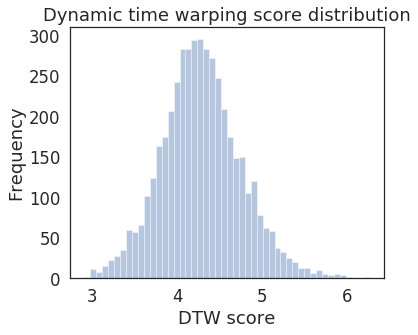

In [27]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.distplot(D_dtw[triu], kde=False)
ax.set_xlabel("DTW score")
ax.set_ylabel("Frequency")
ax.set_title("Dynamic time warping score distribution")
plt.tight_layout()
fig.savefig("../v4/plots/design/dtw_distribution_all_starterseqs.svg")
fig.savefig("../v4/plots/design/dtw_distribution_all_starterseqs.png", dpi=300)

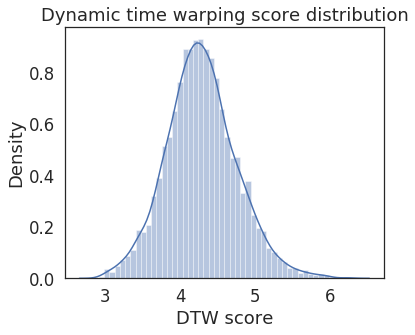

In [28]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.distplot(D_dtw[triu])
ax.set_xlabel("DTW score")
ax.set_ylabel("Density")
ax.set_title("Dynamic time warping score distribution")
plt.tight_layout()
fig.savefig("../v4/plots/design/dtw_distribution_all_density_starterseqs.svg")
fig.savefig("../v4/plots/design/dtw_distribution_all_density_starterseqs.png", dpi=300)

In [29]:
np.mean(D_dtw[triu]), np.std(D_dtw[triu]), np.mean(D_sw[triu]), np.std(D_sw[triu])

(4.28306208901238, 0.46866789151275595, 3.894298245614035, 1.6352109522682308)

In [30]:
np.min(D_dtw[triu]), np.max(D_sw[triu])

(2.9134087562561035, 14.0)

[[0.         3.6275363  4.71666288 3.98183036]
 [3.6275363  0.         4.38016558 4.15841961]
 [4.71666288 4.38016558 0.         4.23319483]
 [3.98183036 4.15841961 4.23319483 0.        ]]
[0.         3.6275363  4.71666288 3.98183036]
[3.6275363  0.         4.38016558 4.15841961]
[4.71666288 4.38016558 0.         4.23319483]


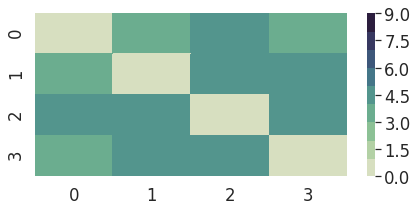

In [59]:
ix = np.array([1, 5, 6, 10])
dtw_1, dtw_5, dtw_6, dtw_10 = D_dtw[ix]
mini_dtw = np.vstack([dtw_1[ix], dtw_5[ix], dtw_6[ix], dtw_10[ix]])
print(mini_dtw)
print(dtw_1[ix])
print(dtw_5[ix])
print(dtw_6[ix])

cmap = sns.cubehelix_palette(9, start=.5, rot=-.75)
fig, ax = plt.subplots(figsize=(7, 3))
ax = sns.heatmap(mini_dtw, cmap=cmap, ax=ax, vmax=9)
fig.savefig("../v4/plots/design/sample_dtw_before.svg")